<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/main/HAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HAC)

**GitHub Repository**: https://github.com/jiaminho/RPH-HAC-Prediction/tree/main

 **MIMIC-III v1.4.**
https://physionet.org/content/mimiciii/1.4/

MIMIC-III is a relational database consisting of 26 tables. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

Five tables are used to define and track patient stays: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS. Another five tables are dictionaries for cross-referencing codes against their respective definitions: D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS. The remaining tables contain data associated with patient care, such as physiological measurements, caregiver observations, and billing information.

- mimic paper: https://www.nature.com/articles/sdata201635
- mimic website github: https://github.com/MIT-LCP/mimic-website
- mimic paper github: https://github.com/MIT-LCP/mimic-iii-paper/tree/master

HAC list: https://www.safetyandquality.gov.au/publications-and-resources/resource-library/hospital-acquired-complications-hacs-list-specifications-version-31-12th-edn

**Import necessary libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Input, Dense
# import umap

2023-08-31 09:37:10.122364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read in files ordered from largest to smallest

### Files < 100Mb

# Most important tables
- lab_item
- admission
- micro-bio events
- diagnosis 
- d_ means description

HADAM_ID: Instance where person comes into hospital.  

- admission: What we get when patient admits to the hospital (not target). Hadam ID is the unique. linked to admission. DOD: Date of Death. DOD_SNN?
- diagnosis: Target table 6 weeks after leaving the table.
- patient: All patient info. Merge with admission. 
- diagnosis_icd and d_diagnosis_icd: one patient can have multiple diagnoses. merge with d_diagnosis_icd. 
- icd_procedures and d_icd_procedures and procedureevents_mv: procedure done on patient. events: real time info on events that occur during procedures.   
     - maybe consider training an autoencoder on the events tables
- lab_events and lab_item: lab test done on the patient. 


notevents and caregivers are connected. 
 admissions and diagnosis
 ICU and procedures
 lab items and micro
 
# Daniel
- procedure and ICU Stays

# Jia Min
- admissions and diagnosis. 

# Leon
- Lab items and micro and prescriptions

# Other tables for future analysis
- d_cpt
- cpt_events
- d_items
- callout
- caregivers and noteevents
- datetimeevents
- drg_codes
- drg_type
- inputevents_cv
- inputsevents_mv
- outputevents
- services
- transfers 

In [3]:
d_cpt = pd.read_csv('/Deep Learning/capstone_project/Data/D_CPT.csv')               # 16K
lab_item = pd.read_csv('/Deep Learning/capstone_project/Data/D_LABITEMS.csv')       # 44K
caregivers = pd.read_csv('/Deep Learning/capstone_project/Data/CAREGIVERS.csv')     # 200K
d_items = pd.read_csv('/Deep Learning/capstone_project/Data/D_ITEMS.csv')           # 936K
d_diagnosis_icd = pd.read_csv('/Deep Learning/capstone_project/Data/D_ICD_DIAGNOSES.csv') # 1.4M
patients = pd.read_csv('/Deep Learning/capstone_project/Data/PATIENTS.csv')         # 2.6M
services = pd.read_csv('/Deep Learning/capstone_project/Data/SERVICES.csv')         # 3.4M
callout = pd.read_csv('/Deep Learning/capstone_project/Data/CALLOUT.csv')           # 6.1M
icustays = pd.read_csv('/Deep Learning/capstone_project/Data/ICUSTAYS.csv')         # 6.1M
procedure = pd.read_csv('/Deep Learning/capstone_project/Data/PROCEDURES_ICD.csv')  # 6.5M
drgcodes = pd.read_csv('/Deep Learning/capstone_project/Data/DRGCODES.csv')         # 11M 
admission = pd.read_csv('/Deep Learning/capstone_project/Data/ADMISSIONS.csv')      # 12M
diagnosis_icd = pd.read_csv('/Deep Learning/capstone_project/Data/DIAGNOSES_ICD.csv')   # 19M
transfers = pd.read_csv('/Deep Learning/capstone_project/Data/TRANSFERS.csv')       # 24M
procedure_events = pd.read_csv('/Deep Learning/capstone_project/Data/PROCEDUREEVENTS_MV.csv') # 47M
cptevents = pd.read_csv('/Deep Learning/capstone_project/Data/CPTEVENTS.csv') # 56M
micro = pd.read_csv('/Deep Learning/capstone_project/Data/MICROBIOLOGYEVENTS.csv')  # 70M

/tmp/ipykernel_585/2250256089.py:16: DtypeWarning: Columns (4,5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cptevents = pd.read_csv('/Deep Learning/capstone_project/Data/CPTEVENTS.csv') # 56M


### Files > 100Mb

In [12]:
outputevents = pd.read_csv('/Deep Learning/capstone_project/Data/OUTPUTEVENTS.csv')  # 379M

In [5]:
datetime_events = pd.read_csv('/Deep Learning/capstone_project/Data/DATETIMEEVENTS.csv') # 502M

/tmp/ipykernel_4886/3768171475.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  datetime_events = pd.read_csv('/Deep Learning/capstone_project/Data/DATETIMEEVENTS.csv') # 502M


In [9]:
prescriptions = pd.read_csv('/Deep Learning/capstone_project/Data/PRESCRIPTIONS.csv') # 735M

/tmp/ipykernel_36/2051229069.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  datetime_events = pd.read_csv('/Deep Learning/capstone_project/Data/DATETIMEEVENTS.csv') # 502M
/tmp/ipykernel_36/2051229069.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('/Deep Learning/capstone_project/Data/PRESCRIPTIONS.csv') # 735M


In [ ]:
inputevents_mv = pd.read_csv('/Deep Learning/capstone_project/Data/INPUTEVENTS_MV.csv') # 931M

In [ ]:
lab_event = pd.read_csv('/Deep Learning/capstone_project/Data/LABEVENTS.csv')       # 1.8G

In [ ]:
noteevents = pd.read_csv('/Deep Learning/capstone_project/Data/NOTEEVENTS.csv')     # 3.5G

## 1. ADMISSIONS.csv

In [89]:
# admission = pd.read_csv('data/ADMISSIONS.csv')
admission.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [90]:
admission.shape

(58976, 19)

There are 58 976 admissions with 19 variables.

In [91]:
missing_values = admission.isnull().sum()
missing_values

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

53 122 values (~ 90.1%) are missing for Deathtime. These missing values likely represent those that survived and hence did not have a time of death. EDREGTIME and EDOUTTIME are both missing 28 099 values (~ 47.6%). 25 332 values (~ 43.0%) are missing for Language. 10 128 values (17.2%) are missing from Marital Status. 458 values (~ 0.8%) are missing for religion. Diagnosis is missing 25 values (~ 0.04%). 

We fill all NA values with Missing.

In [92]:
admission.fillna('Missing', inplace=True)

In [94]:
print("Number of Unique Values for Each Column")
for i in admission.columns.tolist():
    unique_values = len(admission[i].unique())
    print(f"{i}: {unique_values}")

Number of Unique Values for Each Column
ROW_ID: 58976
SUBJECT_ID: 46520
HADM_ID: 58976
ADMITTIME: 58651
DISCHTIME: 58657
DEATHTIME: 5835
ADMISSION_TYPE: 4
ADMISSION_LOCATION: 9
DISCHARGE_LOCATION: 17
INSURANCE: 5
LANGUAGE: 76
RELIGION: 21
MARITAL_STATUS: 8
ETHNICITY: 41
EDREGTIME: 30875
EDOUTTIME: 30865
DIAGNOSIS: 15692
HOSPITAL_EXPIRE_FLAG: 2
HAS_CHARTEVENTS_DATA: 2


In [128]:
lst = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']

# function for plotting verical bar plots
def plot_vertical_categorical_data(column_name, df, top_n):
    df_counts = df[column_name].value_counts()
    top_X = df_counts.head(top_n)
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_X.index, y=top_X.values)
    
    plt.title('Top '+str(top_n)+' Most Common ' + column_name)
    plt.xlabel(column_name)
    plt.ylabel('Number of Admissions')
    plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
    plt.tight_layout()
    plt.show()

# function for plotting horizontal bar plots
def plot_horizontal_categorical_data(column_name, df):
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y=column_name, order = df[column_name].value_counts().index)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel('Number of Patients')
    plt.tight_layout()
    plt.show()

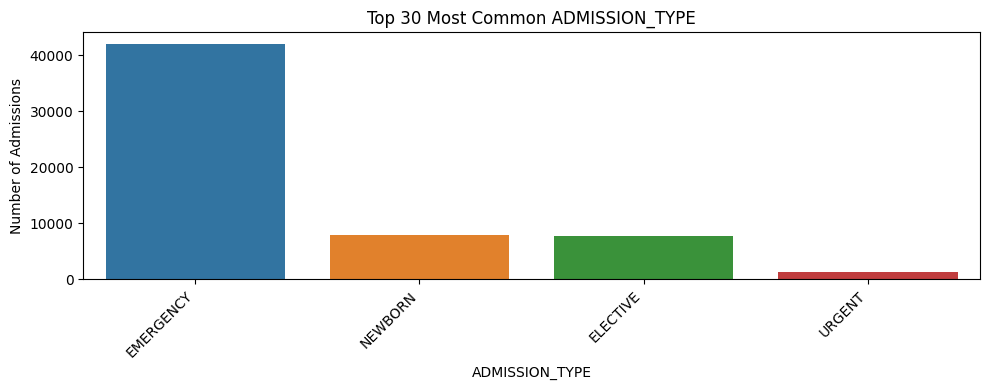

In [129]:
plot_vertical_categorical_data(column_name= 'ADMISSION_TYPE', df=admission, top_n=30)

These are the most common diagnosis

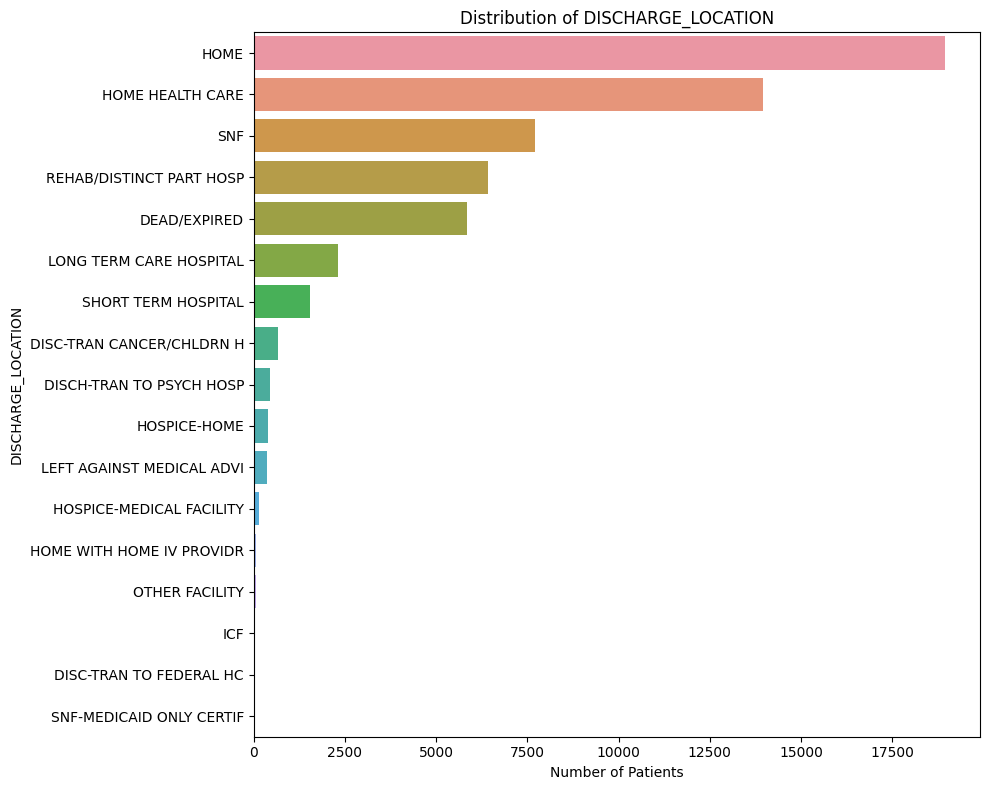

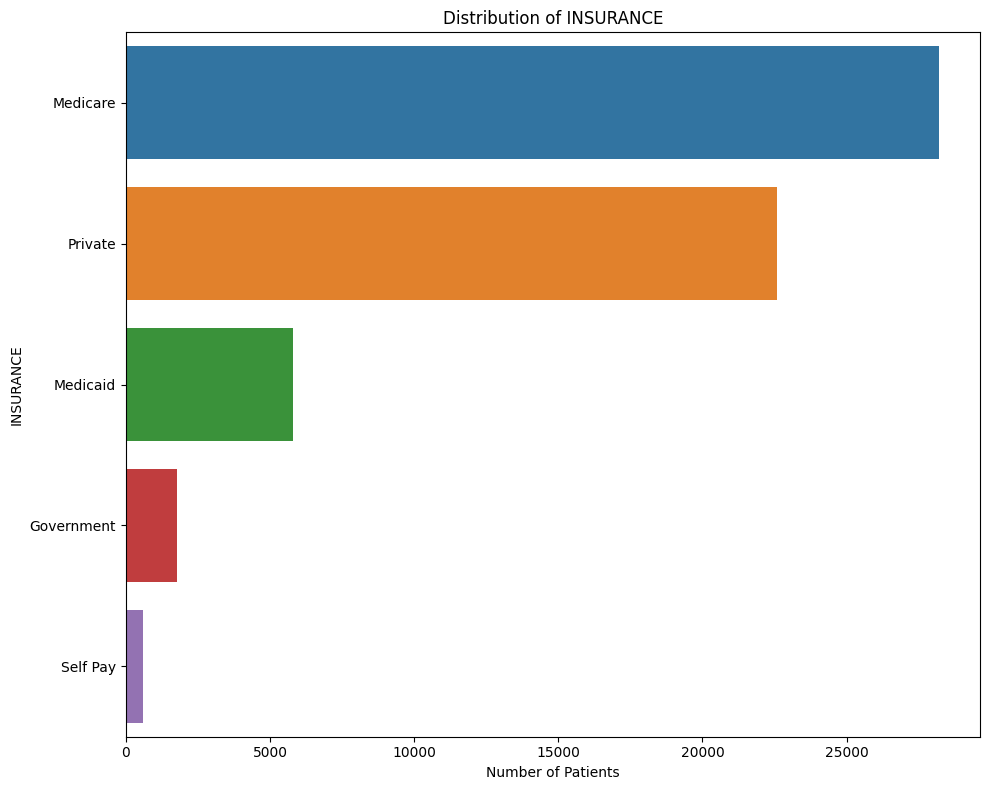

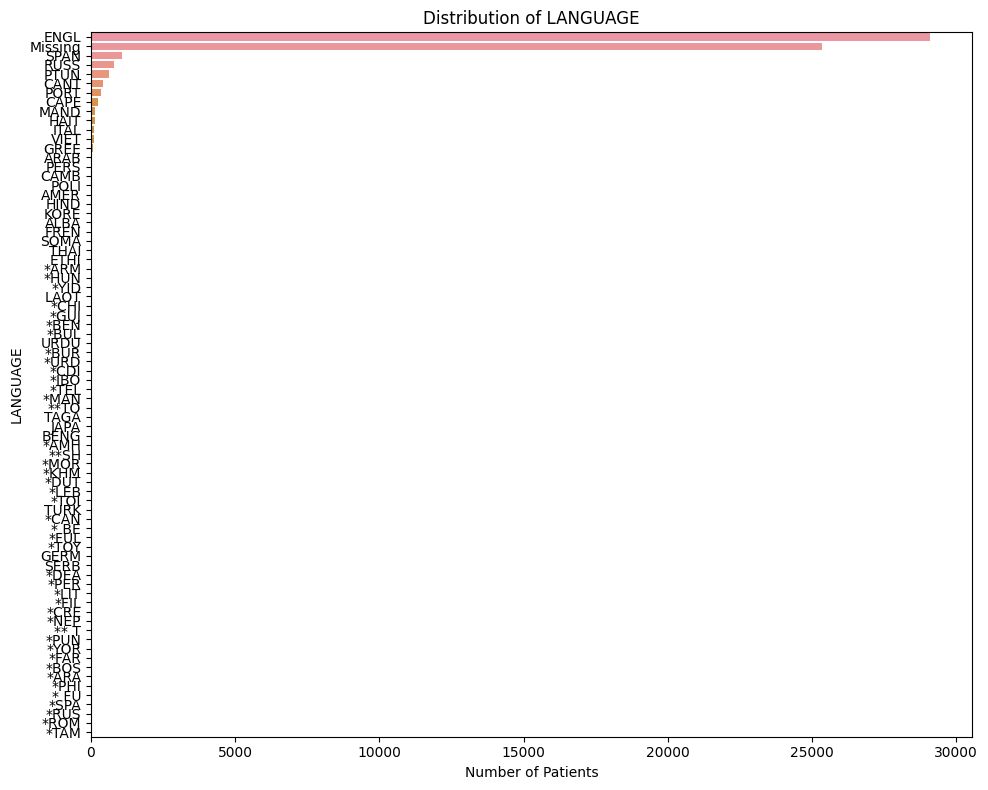

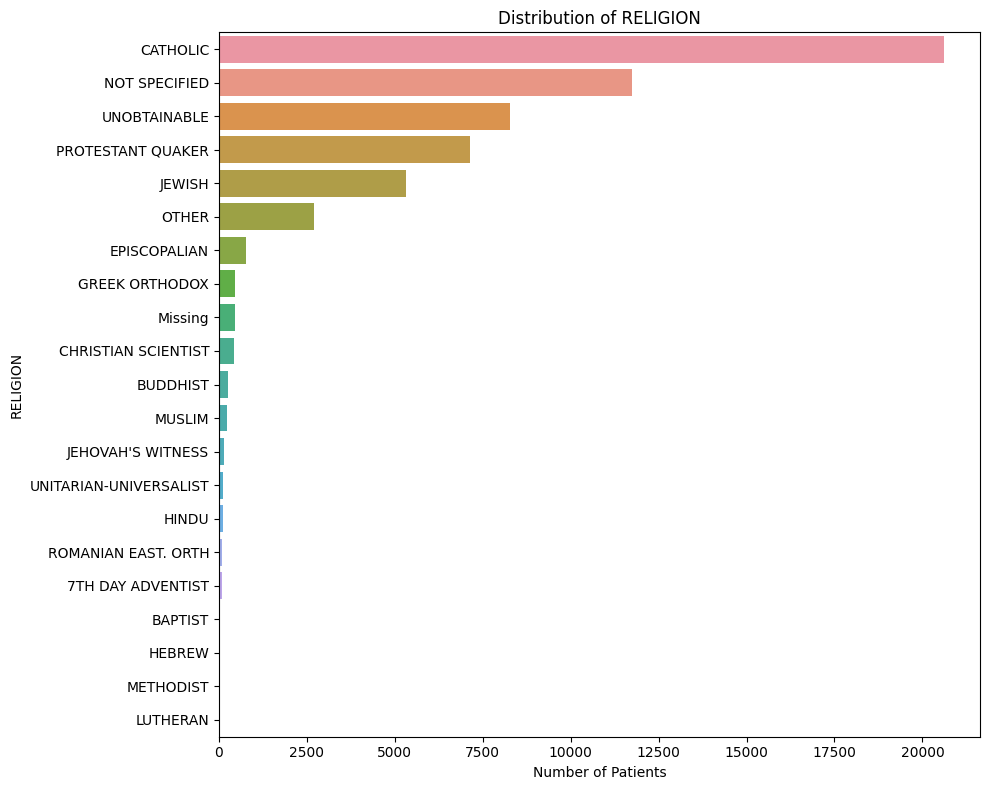

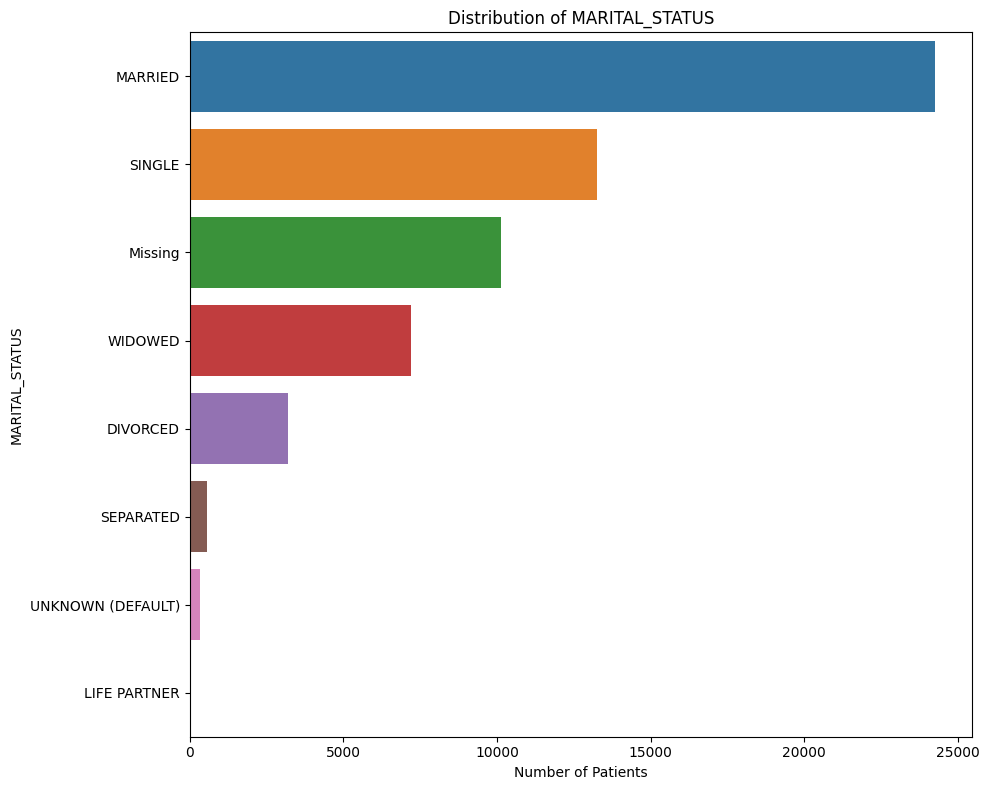

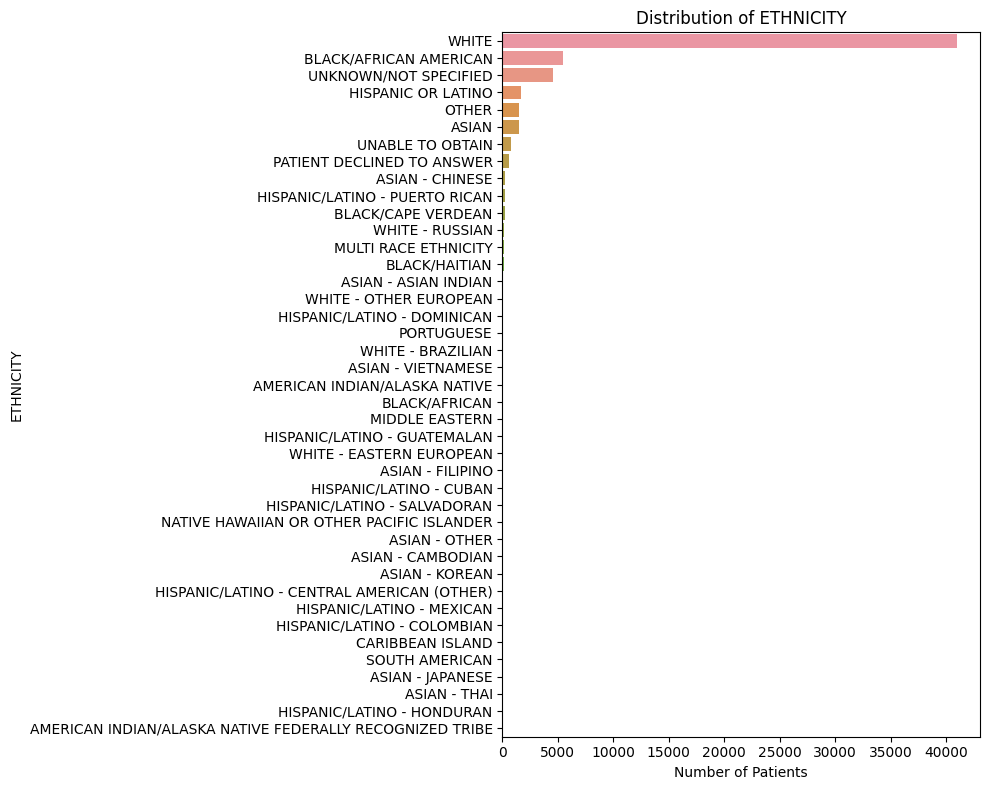

/tmp/ipykernel_4886/4088294256.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


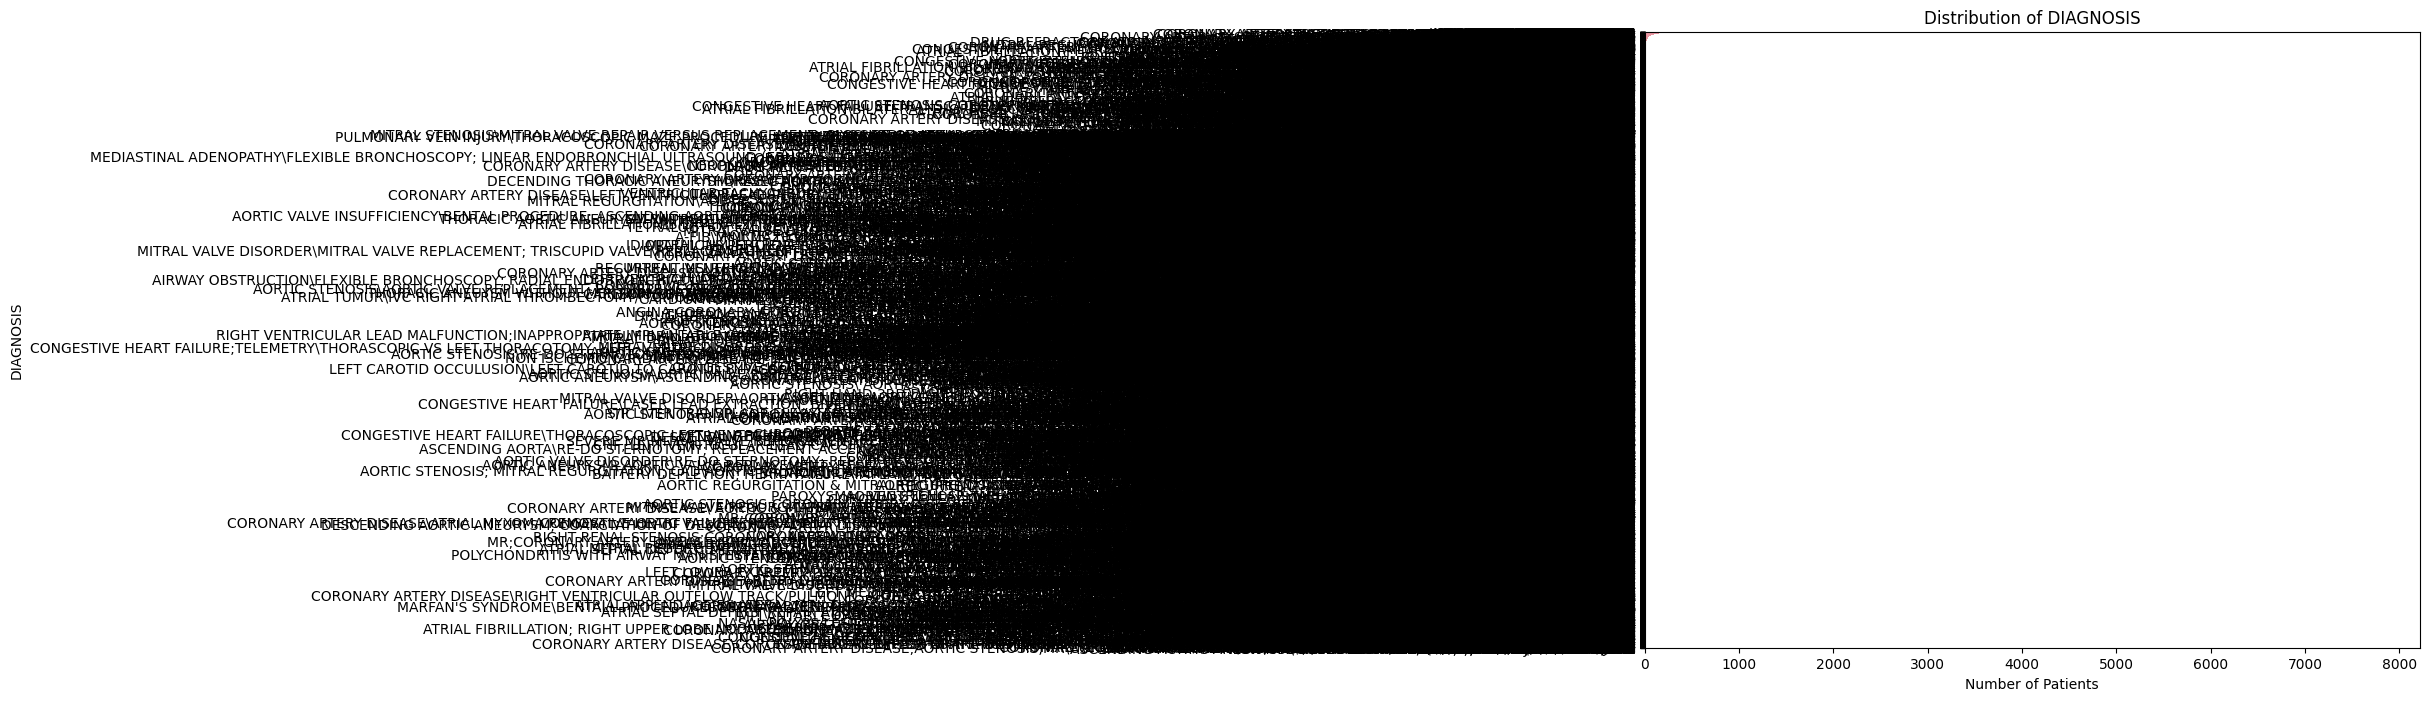

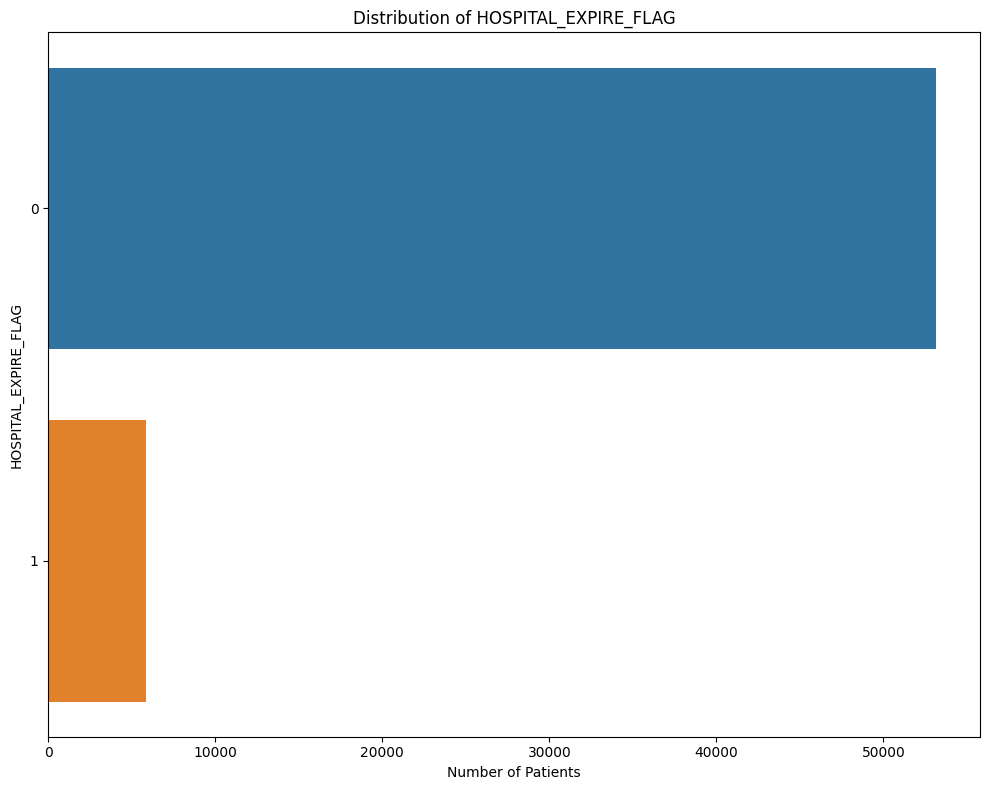

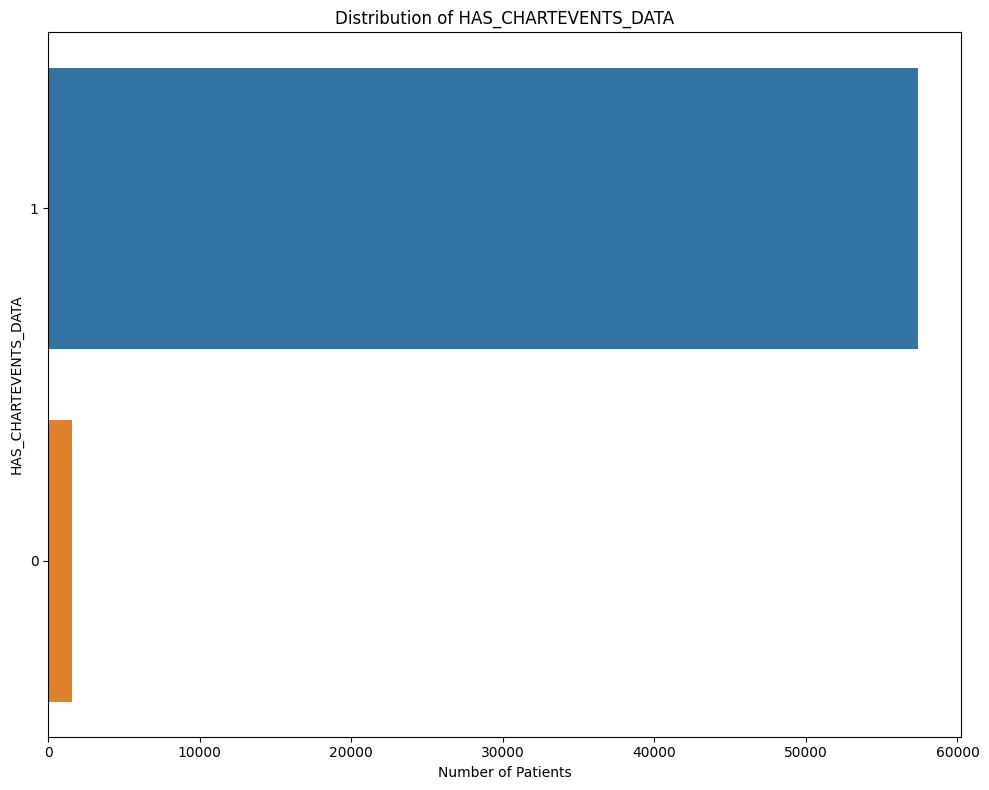

In [131]:
def plot_horizontal_categorical_data(column_name, df):
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y=column_name, order = df[column_name].value_counts().index)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel('Number of Patients')
    plt.tight_layout()
    plt.show()

# Visualizing each column
lst = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']
for column in ['DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']:
    plot_horizontal_categorical_data(column, admission)


## 2. PATIENTS.csv

In [20]:
patients = pd.read_csv('/Deep Learning/capstone_project/Data/PATIENTS.csv')
patients

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
46515,31840,44089,M,2026-05-25 00:00:00,NaN,NaN,NaN,0
46516,31841,44115,F,2124-07-27 00:00:00,NaN,NaN,NaN,0
46517,31842,44123,F,2049-11-26 00:00:00,2135-01-12 00:00:00,2135-01-12 00:00:00,NaN,1
46518,31843,44126,F,2076-07-25 00:00:00,NaN,NaN,NaN,0


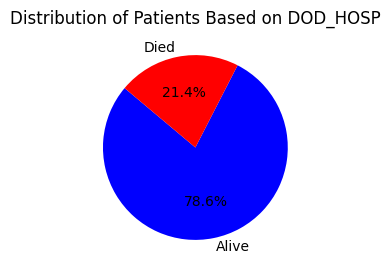

In [21]:
# Create a new column 'DEATH_HOSP' to classify patients died in hospital
patients['DEATH_HOSP'] = patients['DOD_HOSP'].apply(lambda x: 'Died' if pd.notna(x) else 'Alive')

# Get the counts of each category
death_counts = patients['DEATH_HOSP'].value_counts()

# Plot
plt.figure(figsize=(5,3))
plt.pie(death_counts, labels=death_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'red'])
plt.title('Distribution of Patients Based on DOD_HOSP')
plt.show()

show distribution of gender

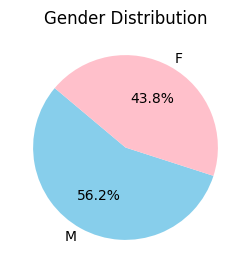

In [22]:
# Count occurrences of each gender
gender_counts = patients['GENDER'].value_counts()

# Plot pie chart
plt.figure(figsize=(5, 3))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'pink'])
plt.title('Gender Distribution')
plt.show()

### Merge patient data with admission data

In [ ]:
# Merge patients with admission using a left merge
admission_merged = pd.merge(admission, patients, on='SUBJECT_ID', how='left')
admission_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,DEATH_STATUS,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DEATH_HOSP
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,Alive,19,F,2131-05-07 00:00:00,NaN,NaN,NaN,0,Alive
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,Alive,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,Alive
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,Alive,20,M,2082-07-17 00:00:00,NaN,NaN,NaN,0,Alive
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,Alive,21,M,2100-05-31 00:00:00,NaN,NaN,NaN,0,Alive
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,Alive,22,M,2101-11-21 00:00:00,NaN,NaN,NaN,0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,1,Alive,46213,F,2111-11-05 00:00:00,NaN,NaN,NaN,0,Alive
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,1,Died,46214,F,2067-09-21 00:00:00,2151-03-06 00:00:00,2151-03-06 00:00:00,NaN,1,Died
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,1,Alive,46215,M,2158-03-02 00:00:00,NaN,NaN,NaN,0,Alive
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,0,Alive,46216,F,2068-02-04 00:00:00,NaN,NaN,NaN,0,Alive


In [ ]:
duplicated_count = admission_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


**Calculate the age** of each patient using the 'DOB' column. However, it's essential to be aware that dates in MIMIC-III have been shifted to protect patient privacy. Therefore, we're calculating a pseudonymized age rather than the actual age.

In [ ]:
# Convert ADMITTIME and DOB to datetime format
admission_merged['ADMITTIME'] = pd.to_datetime(admission_merged['ADMITTIME'])
admission_merged['DOB'] = pd.to_datetime(admission_merged['DOB'])


def calculate_age(admit_time, dob):
    try:
        # Convert pandas timestamps to Python datetime objects
        admit_datetime = admit_time.to_pydatetime()
        dob_datetime = dob.to_pydatetime()

        # Calculate age
        age = (admit_datetime - dob_datetime).days // 365.25
        return age if age > 0 else np.nan  # Assign NaN for negative ages
    except OverflowError:
        return np.nan

# Use the 'apply' method with the function
admission_merged['AGE_AT_ADMISSION'] = admission_merged.apply(lambda row: calculate_age(row['ADMITTIME'], row['DOB']), axis=1)
admission_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DEATH_STATUS,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DEATH_HOSP,AGE_AT_ADMISSION
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,Alive,19,F,2131-05-07,NaN,NaN,NaN,0,Alive,64.0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,Alive,20,M,2082-07-17,NaN,NaN,NaN,0,Alive,71.0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,Alive,20,M,2082-07-17,NaN,NaN,NaN,0,Alive,75.0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,Alive,21,M,2100-05-31,NaN,NaN,NaN,0,Alive,39.0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,Alive,22,M,2101-11-21,NaN,NaN,NaN,0,Alive,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,Alive,46213,F,2111-11-05,NaN,NaN,NaN,0,Alive,19.0
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,Died,46214,F,2067-09-21,2151-03-06 00:00:00,2151-03-06 00:00:00,NaN,1,Died,83.0
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,Alive,46215,M,2158-03-02,NaN,NaN,NaN,0,Alive,42.0
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,Alive,46216,F,2068-02-04,NaN,NaN,NaN,0,Alive,60.0


count NaN in age

In [ ]:
nan_count = admission_merged['AGE_AT_ADMISSION'].isna().sum()
print(f"The number of NaN values in the 'AGE_AT_ADMISSION' column is: {nan_count}")

The number of NaN values in the 'AGE_AT_ADMISSION' column is: 8110


## 3. DIAGNOSES_ICD.csv

DIAGNOSES_ICD- only when discharged

In [23]:
# diagnosis = pd.read_csv('data/DIAGNOSES_ICD.csv')
diagnosis

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


In [24]:
diagnosis['ICD9_CODE'].isnull().sum()

47

47 admitted patients do not have ICD9_CODE

## 4. D_ICD_DIAGNOSES.csv

In [25]:
# diagnosis_icd = pd.read_csv('data/D_ICD_DIAGNOSES.csv')
diagnosis_icd

FileNotFoundError: [Errno 2] No such file or directory: 'data/D_ICD_DIAGNOSES.csv'

### Merge patient's (HADM_ID) diagnosis ICD9_CODE to their respective names

In [ ]:
# Convert the ICD9_CODE columns in all DataFrames to string data type
diagnosis_icd['ICD9_CODE'] = diagnosis_icd['ICD9_CODE'].astype(str)
diagnosis['ICD9_CODE'] = diagnosis['ICD9_CODE'].astype(str)

# Merge diagnosis with diagnosis_icd using a left merge
diagnosis_merged = pd.merge(diagnosis, diagnosis_icd, on='ICD9_CODE', how='left')
diagnosis_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,1297,109,172335,1.0,40301,4312.0,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
1,1298,109,172335,2.0,486,5528.0,"Pneumonia, organism NOS","Pneumonia, organism unspecified"
2,1299,109,172335,3.0,58281,5892.0,Chr nephritis in oth dis,Chronic glomerulonephritis in diseases classif...
3,1300,109,172335,4.0,5855,5913.0,Chron kidney dis stage V,"Chronic kidney disease, Stage V"
4,1301,109,172335,5.0,4254,4435.0,Prim cardiomyopathy NEC,Other primary cardiomyopathies
...,...,...,...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280,1859.0,Oth lymp unsp xtrndl org,"Other malignant lymphomas, unspecified site, e..."
651043,639799,97503,188195,3.0,V5869,12800.0,Long-term use meds NEC,Long-term (current) use of other medications
651044,639800,97503,188195,4.0,V1279,13957.0,Prsnl hst ot spf dgst ds,Personal history of other diseases of digestiv...
651045,639801,97503,188195,5.0,5275,5971.0,Sialolithiasis,Sialolithiasis


In [ ]:
duplicated_count = diagnosis_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


**Most Common ICD-9 Codes**

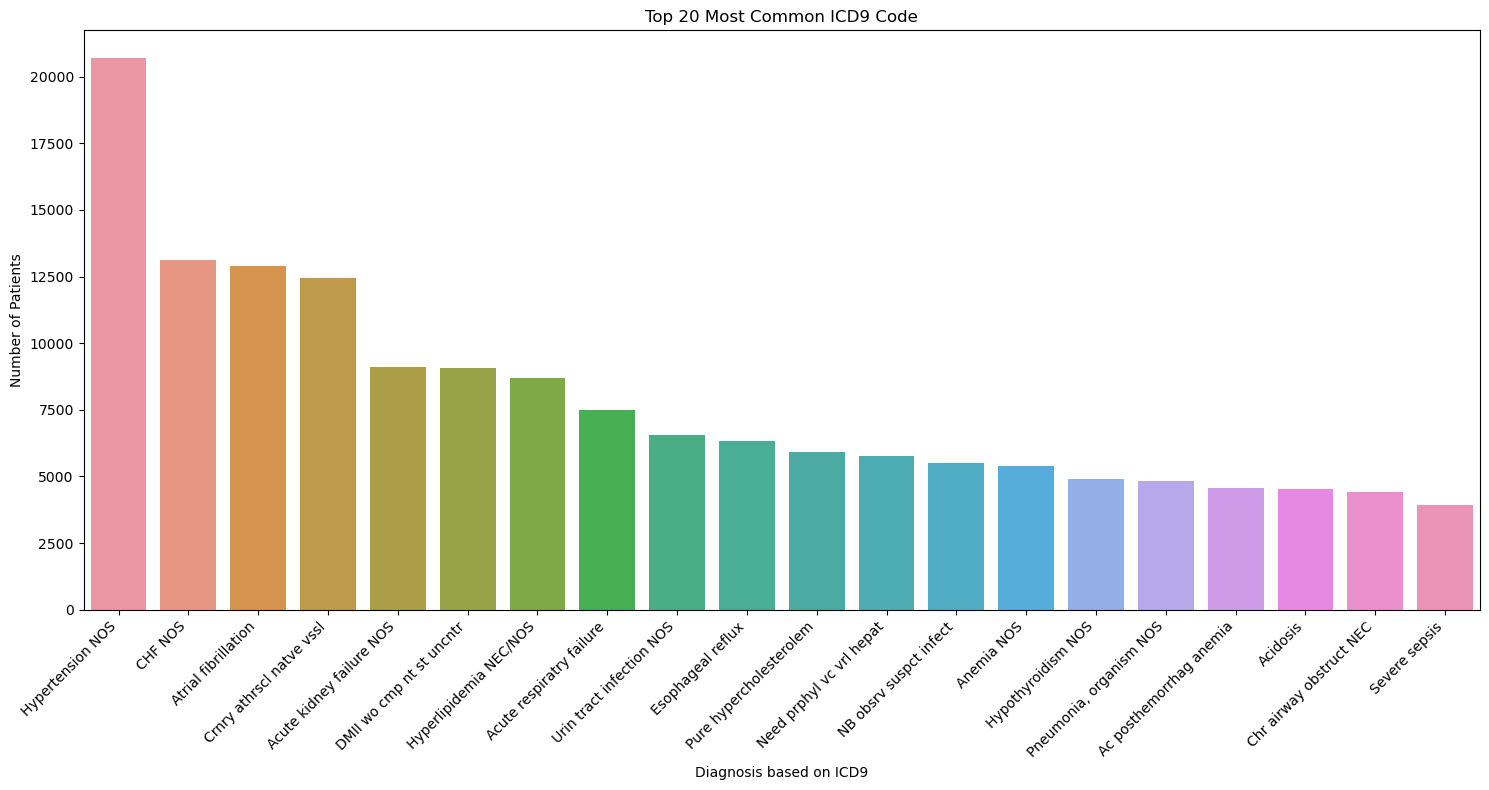

In [ ]:
# Count the occurrences of each icd
icd_counts = diagnosis_merged['SHORT_TITLE'].value_counts()

# Take the top 20 most common icd
top_icd = icd_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_icd.index, y=top_icd.values)
plt.title('Top 20 Most Common ICD9 Code')
plt.xlabel('Diagnosis based on ICD9')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
plt.tight_layout()
plt.show()

The bar chart above shows the top 20 most common ICD9 code.

Filter the diagnosis_merged table for the specific HADM_ID of 188195 and then retrieve the ICD9_CODE and SHORT_TITLE values associated with it

In [ ]:
# Filter for HADM_ID 188195
diagnosis188195 = diagnosis_merged[diagnosis_merged['HADM_ID'] == 188195][['ICD9_CODE', 'SHORT_TITLE']]

# Display the filtered data
print(diagnosis188195)


       ICD9_CODE               SHORT_TITLE
646694     28529  Anemia-other chronic dis
646695     07032  Hpt B chrn wo cm wo dlta
651041      7842   Swelling in head & neck
651042     20280  Oth lymp unsp xtrndl org
651043     V5869    Long-term use meds NEC
651044     V1279  Prsnl hst ot spf dgst ds
651045      5275            Sialolithiasis
651046      5569  Ulceratve colitis unspcf


This shows that one patient can have multiple diagnosis.

## 5. PROCEDURES_ICD.csv

In [ ]:
# procedure = pd.read_csv('data/PROCEDURES_ICD.csv')
procedure

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,331
...,...,...,...,...,...
240090,228330,67415,150871,5,3736
240091,228331,67415,150871,6,3893
240092,228332,67415,150871,7,8872
240093,228333,67415,150871,8,3893


## 6. D_ICD_PROCEDURES.csv

In [ ]:
# procedure_icd = pd.read_csv('data/D_ICD_PROCEDURES.csv')
procedure_icd

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,851,Canthotomy,Canthotomy
1,265,852,Blepharorrhaphy,Blepharorrhaphy
2,266,859,Adjust lid position NEC,Other adjustment of lid position
3,267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...
...,...,...,...,...
3877,3344,9959,Vaccination/innocula NEC,Other vaccination and inoculation
3878,3345,9960,Cardiopulm resuscita NOS,"Cardiopulmonary resuscitation, not otherwise s..."
3879,3346,9961,Atrial cardioversion,Atrial cardioversion
3880,3347,9962,Heart countershock NEC,Other electric countershock of heart


Check for duplicates in the procedure_icd table.

In [ ]:
# Count occurrences of each ICD9_CODE in procedure_icd
icd_counts = procedure_icd['ICD9_CODE'].value_counts()

# Filter out ICD9_CODE values that occur only once (i.e., retain only duplicates)
duplicates = icd_counts[icd_counts > 1]

print(duplicates)

101    2
613    2
714    2
713    2
700    2
      ..
111    2
863    2
110    2
96     2
412    2
Name: ICD9_CODE, Length: 73, dtype: int64


In [ ]:
# Find duplicated ICD9_CODE values in procedure_icd
duplicated_icd_codes = procedure_icd[procedure_icd['ICD9_CODE'].duplicated(keep=False)]

# Sort them by ICD9_CODE for easier inspection
duplicated_icd_codes_sorted = duplicated_icd_codes.sort_values(by='ICD9_CODE')

# Display the sorted duplicated rows
print(duplicated_icd_codes_sorted)


      ROW_ID  ICD9_CODE               SHORT_TITLE  \
449      261         16       Excise skull lesion   
335      147         16   Pressurized treat graft   
437      249         31  Intraspin nerve root div   
346      158         31              CAS w CT/CTA   
378      190         34  Excis spinal cord lesion   
...      ...        ...                       ...   
2063    2063        843    Amputation stump revis   
5        269        863  Lid reconst w hair graft   
3399    3479        863  Other local destruc skin   
6        270        864  Lid recon-tarsoconj flap   
3400    3480        864    Radical excis skin les   

                                             LONG_TITLE  
449                         Excision of lesion of skull  
335   Pressurized treatment of venous bypass graft [...  
437                  Division of intraspinal nerve root  
346               Computer assisted surgery with CT/CTA  
378   Excision or destruction of lesion of spinal co...  
...            

Combine data from duplicated rows. Concatenate the descriptions for the same ICD code


In [ ]:
# combine the descriptions for the same ICD code
procedure_icd['SHORT_TITLE'] = procedure_icd.groupby('ICD9_CODE')['SHORT_TITLE'].transform(lambda x: ' | '.join(x))
procedure_icd['LONG_TITLE'] = procedure_icd.groupby('ICD9_CODE')['LONG_TITLE'].transform(lambda x: ' | '.join(x))

procedure_icd_cleaned = procedure_icd.drop_duplicates(subset='ICD9_CODE', keep='first')
procedure_icd_cleaned

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,851,Canthotomy,Canthotomy
1,265,852,Blepharorrhaphy,Blepharorrhaphy
2,266,859,Adjust lid position NEC,Other adjustment of lid position
3,267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
4,268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...
...,...,...,...,...
3877,3344,9959,Vaccination/innocula NEC,Other vaccination and inoculation
3878,3345,9960,Cardiopulm resuscita NOS,"Cardiopulmonary resuscitation, not otherwise s..."
3879,3346,9961,Atrial cardioversion,Atrial cardioversion
3880,3347,9962,Heart countershock NEC,Other electric countershock of heart


### Merge patient's (HADM_ID) procedure ICD9_CODE to their respective names

In [ ]:
# Convert the ICD9_CODE columns in all DataFrames to string data type
procedure_icd_cleaned = procedure_icd_cleaned.copy()
procedure_icd_cleaned['ICD9_CODE'] = procedure_icd_cleaned['ICD9_CODE'].astype(str)
procedure['ICD9_CODE'] = procedure['ICD9_CODE'].astype(str)

# Merge procedure with procedure_icd using a left merge
procedure_merged = pd.merge(procedure, procedure_icd_cleaned, on='ICD9_CODE', how='left')
procedure_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
0,944,62641,154460,3,3404,496.0,Insert intercostal cath,Insertion of intercostal catheter for drainage
1,945,2592,130856,1,9671,3678.0,Cont inv mec ven <96 hrs,Continuous invasive mechanical ventilation for...
2,946,2592,130856,2,3893,801.0,Venous cath NEC,"Venous catheterization, not elsewhere classified"
3,947,55357,119355,1,9672,3679.0,Cont inv mec ven 96+ hrs,Continuous invasive mechanical ventilation for...
4,948,55357,119355,2,331,187.0,Spinal tap | Incision of lung,Spinal tap | Incision of lung
...,...,...,...,...,...,...,...,...
240090,228330,67415,150871,5,3736,1300.0,"Exc,destrct,exclus LAA","Excision, destruction, or exclusion of left at..."
240091,228331,67415,150871,6,3893,801.0,Venous cath NEC,"Venous catheterization, not elsewhere classified"
240092,228332,67415,150871,7,8872,3233.0,Dx ultrasound-heart,Diagnostic ultrasound of heart
240093,228333,67415,150871,8,3893,801.0,Venous cath NEC,"Venous catheterization, not elsewhere classified"


In [ ]:
duplicated_count = procedure_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


Show top 20 procedures being performed in the hospital

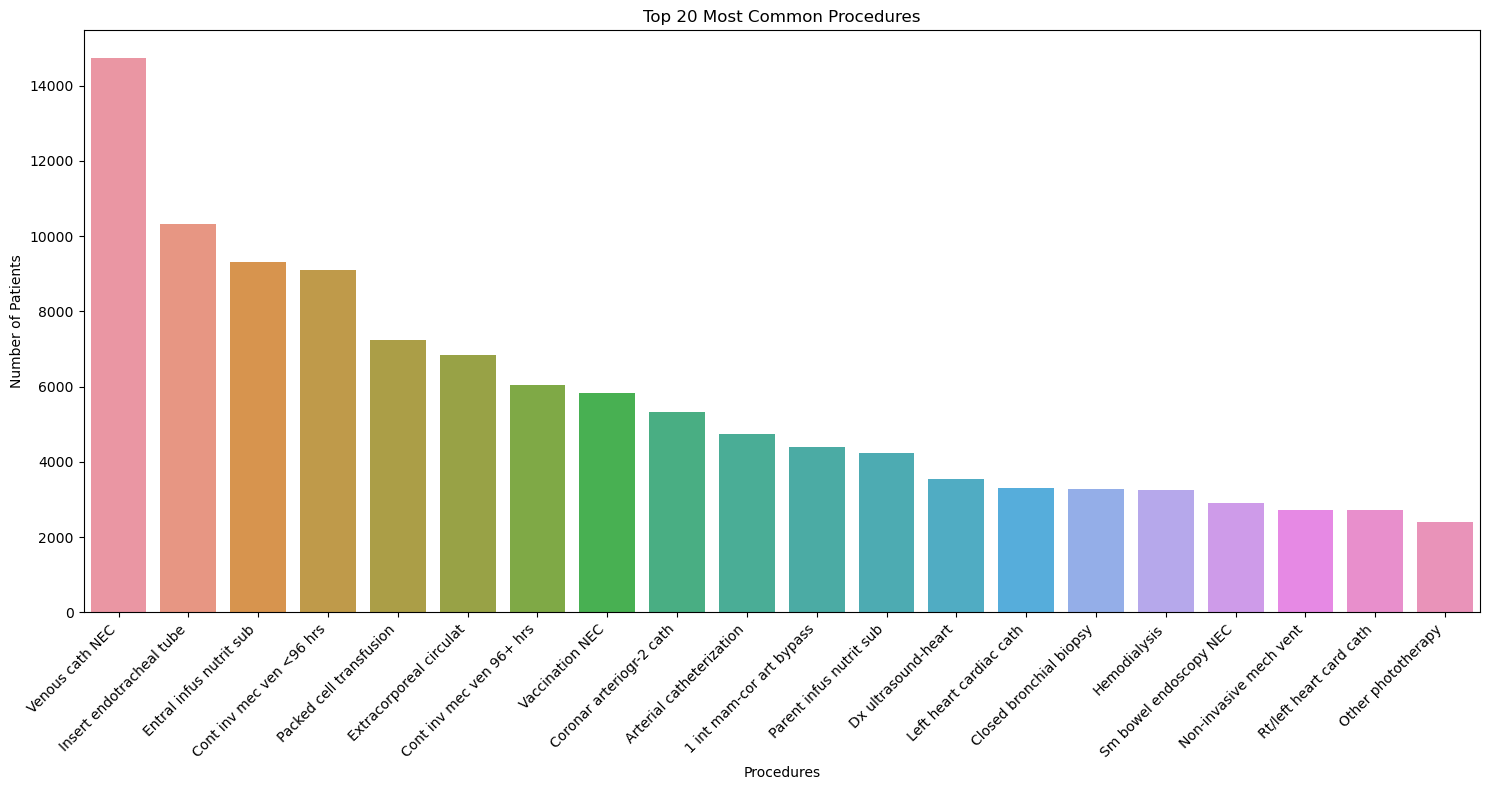

In [ ]:
# Count the occurrences of each icd
procedure_counts = procedure_merged['SHORT_TITLE'].value_counts()

# Take the top 20 most common icd
top_precedure = procedure_counts.head(20)

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=top_precedure.index, y=top_precedure.values)
plt.title('Top 20 Most Common Procedures')
plt.xlabel('Procedures')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')  # Rotate the procedures names for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Filter for HADM_ID 150871
procedures150871 = procedure_merged[procedure_merged['HADM_ID'] == 150871][['ICD9_CODE', 'SHORT_TITLE']]

# Display the filtered data
print(procedures150871)

       ICD9_CODE               SHORT_TITLE
232505      8856  Coronar arteriogr-2 cath
240086      3523  Opn/oth rep mtrl vlv-tis
240087      3733  Exc/dest hrt lesion open
240088      3961   Extracorporeal circulat
240089      3727           Cardiac mapping
240090      3736    Exc,destrct,exclus LAA
240091      3893           Venous cath NEC
240092      8872       Dx ultrasound-heart
240093      3893           Venous cath NEC
240094      3722   Left heart cardiac cath


This shows one admission can also have multiple procedures

## 7. PROCEDUREEVENTS_MV.csv

In [20]:
procedure_events.columns.tolist()

['ROW_ID',
 'SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'STARTTIME',
 'ENDTIME',
 'ITEMID',
 'VALUE',
 'VALUEUOM',
 'LOCATION',
 'LOCATIONCATEGORY',
 'STORETIME',
 'CGID',
 'ORDERID',
 'LINKORDERID',
 'ORDERCATEGORYNAME',
 'SECONDARYORDERCATEGORYNAME',
 'ORDERCATEGORYDESCRIPTION',
 'ISOPENBAG',
 'CONTINUEINNEXTDEPT',
 'CANCELREASON',
 'STATUSDESCRIPTION',
 'COMMENTS_EDITEDBY',
 'COMMENTS_CANCELEDBY',
 'COMMENTS_DATE']

## 8. D_LABITEMS.csv

In [ ]:
# lab_item = pd.read_csv('data/D_LABITEMS.csv')
lab_item

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN
...,...,...,...,...,...,...
748,749,51551,VOIDED SPECIMEN,OTHER BODY FLUID,HEMATOLOGY,NaN
749,750,51552,VOIDED SPECIMEN,STOOL,CHEMISTRY,NaN
750,751,51553,VOIDED SPECIMEN,URINE,CHEMISTRY,NaN
751,752,51554,VOIDED SPECIMEN,JOINT FLUID,HEMATOLOGY,NaN


## 9. LABEVENTS.csv

In [ ]:
# lab_event = pd.read_csv('data/LABEVENTS.csv')
lab_event

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
...,...,...,...,...,...,...,...,...,...
27854050,27428435,96443,103219.0,50882,2109-12-30 01:40:00,26,26.00,mEq/L,NaN
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.10,mg/dL,abnormal
27854052,27428437,96443,103219.0,50902,2109-12-30 01:40:00,97,97.00,mEq/L,NaN
27854053,27428438,96443,103219.0,50911,2109-12-30 01:40:00,2,2.00,ng/mL,NaN


### Merge lab items with lab events

In [ ]:
# Merge lab_event with lab_item using a left merge
lab_merged = pd.merge(lab_event, lab_item, on='ITEMID', how='left')
lab_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ROW_ID_y,LABEL,FLUID,CATEGORY,LOINC_CODE
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN,21,pH,Blood,Blood Gas,11558-4
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN,1,SPECIMEN TYPE,BLOOD,BLOOD GAS,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN,3,Base Excess,Blood,Blood Gas,11555-0
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN,5,Calculated Total CO2,Blood,Blood Gas,34728-6
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal,9,Free Calcium,Blood,Blood Gas,1994-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27854050,27428435,96443,103219.0,50882,2109-12-30 01:40:00,26,26.00,mEq/L,NaN,83,Bicarbonate,Blood,Chemistry,1963-8
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.10,mg/dL,abnormal,86,"Bilirubin, Total",Blood,Chemistry,1975-2
27854052,27428437,96443,103219.0,50902,2109-12-30 01:40:00,97,97.00,mEq/L,NaN,103,Chloride,Blood,Chemistry,2075-0
27854053,27428438,96443,103219.0,50911,2109-12-30 01:40:00,2,2.00,ng/mL,NaN,112,"Creatine Kinase, MB Isoenzyme",Blood,Chemistry,6773-6


In [ ]:
duplicated_count = lab_merged.duplicated().sum()
print(f"Number of duplicated rows: {duplicated_count}")

Number of duplicated rows: 0


Show lab category

In [ ]:
# Get the counts for each unique value in CATEGORY
category_counts = lab_merged['CATEGORY'].value_counts()

print(category_counts)

Hematology    11872248
Chemistry     10971567
Blood Gas      4593241
BLOOD GAS       404785
CHEMISTRY        12201
HEMATOLOGY          13
Name: CATEGORY, dtype: int64


There are mainly 3 categories here. **Hematology, Chemistry and Blood Gas** are repeated in uppercase letter.

A blood gas test, often referred to as an arterial blood gas (ABG) test, is a procedure that measures the amounts of oxygen and carbon dioxide in the blood, as well as the balance of acid and base (pH level). It provides information about how well the lungs are able to move oxygen into the blood and remove carbon dioxide from the blood.

In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Blood Gas'
bloodgas_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'blood gas']

# Get unique values in the 'LABEL' column
bloodgas_labels = bloodgas_df['LABEL'].unique()
print(bloodgas_labels)

['pH' 'SPECIMEN TYPE' 'Base Excess' 'Calculated Total CO2' 'Free Calcium'
 'Intubated' 'Lactate' 'pCO2' 'pO2' 'Temperature' 'Oxygen'
 'Oxygen Saturation' 'PEEP' 'Tidal Volume' 'Ventilation Rate' 'Ventilator'
 'Hematocrit, Calculated' 'Hemoglobin' 'Glucose' 'Potassium, Whole Blood'
 'Alveolar-arterial Gradient' 'Required O2' 'Sodium, Whole Blood'
 'Calculated Bicarbonate, Whole Blood' 'Chloride, Whole Blood' 'O2 Flow'
 'Methemoglobin' 'Carboxyhemoglobin' 'Fluid Type' 'pO2, Body Fluid'
 'pCO2, Body Fluid' 'Potassium' 'Sodium, Body Fluid']


In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Hematology'
hematology_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'hematology']

# Get unique values in the 'LABEL' column
hematology_labels = hematology_df['LABEL'].unique()
print(hematology_labels)

['Hematocrit' 'Anisocytosis' 'Basophils' 'Eosinophils' 'Hemoglobin'
 'Hypochromia' 'Lymphocytes' 'Macrocytes' 'MCH' 'MCHC' 'MCV' 'Microcytes'
 'Monocytes' 'Neutrophils' 'Platelet Count' 'Poikilocytosis' 'RDW'
 'Red Blood Cell Fragments' 'Red Blood Cells' 'White Blood Cells'
 'Bilirubin' 'Blood' 'Glucose' 'Ketone' 'Leukocytes' 'Nitrite' 'pH'
 'Protein' 'Specific Gravity' 'Urine Appearance' 'Urine Color'
 'Urobilinogen' 'Bacteria' 'Epithelial Cells' 'Hyaline Casts' 'RBC'
 'Urine Mucous' 'WBC' 'Yeast' 'PTT' 'INR(PT)' 'PT'
 'Fibrinogen, Functional' 'Atypical Lymphocytes' 'Bands' 'Metamyelocytes'
 'Myelocytes' 'Polychromasia' 'Nucleated Red Cells' 'Platelet Smear'
 'Absolute CD3 Count' 'Absolute CD4 Count' 'Absolute CD8 Count'
 'Absolute Lymphocyte Count' 'CD3 Cells, Percent' 'CD4 Cells, Percent'
 'CD4/CD8 Ratio' 'CD8 Cells, Percent' 'Lymphocytes, Percent' 'WBC Count'
 'Transitional Epithelial Cells' 'D-Dimer' 'Fibrin Degradation Products'
 'Reticulocyte Count, Automated' 'Burr Cells' 'WBC 

In [ ]:
# Filter the DataFrame for rows where CATEGORY is 'Chemistry'
chemistry_df = lab_merged[lab_merged['CATEGORY'].str.lower() == 'chemistry']

# Get unique values in the 'LABEL' column
chemistry_labels = chemistry_df['LABEL'].unique()
print(chemistry_labels)

['Anion Gap' 'Bicarbonate' 'Calcium, Total' 'Chloride' 'Creatinine'
 'Glucose' 'Magnesium' 'Phosphate' 'Potassium' 'Sodium' 'Urea Nitrogen'
 'Vancomycin' 'Alanine Aminotransferase (ALT)'
 'Asparate Aminotransferase (AST)' 'Creatine Kinase (CK)'
 'Creatine Kinase, MB Isoenzyme' 'Troponin I' 'Alkaline Phosphatase'
 'Bilirubin, Total' 'Albumin' 'Amylase' 'Lipase' 'Uric Acid'
 'Bilirubin, Direct' 'Bilirubin, Indirect' 'Cholesterol Ratio (Total/HDL)'
 'Cholesterol, HDL' 'Cholesterol, LDL, Measured' 'Cholesterol, Total'
 'Triglycerides' 'Blue Top Hold' 'Gamma Glutamyltransferase'
 'Lactate Dehydrogenase (LD)' 'Chloride, Urine' 'Creatinine, Urine'
 'Length of Urine Collection' 'Osmolality, Urine' 'Sodium, Urine'
 'Urea Nitrogen, Urine' 'Ferritin' 'Iron' 'Iron Binding Capacity, Total'
 'Transferrin' 'CK-MB Index' 'Osmolality, Measured' 'Red Top Hold'
 'Thyroid Stimulating Hormone' 'Thyroxine (T4)' 'Green Top Hold (plasma)'
 'Cholesterol, LDL, Calculated' 'GR HOLD' '% Hemoglobin A1c' 'EDTA Hold

In [ ]:
# Get the counts for each unique value in CATEGORY
fluid_counts = lab_merged['FLUID'].value_counts()

print(fluid_counts)

Blood                        25341470
Urine                         1964068
BLOOD                          405141
Cerebrospinal Fluid (CSF)       35917
Ascites                         31224
Pleural                         28393
Other Body Fluid                24667
URINE                           11850
Bone Marrow                      5368
Joint Fluid                      5319
Stool                             630
OTHER BODY FLUID                    6
JOINT FLUID                         2
Name: FLUID, dtype: int64


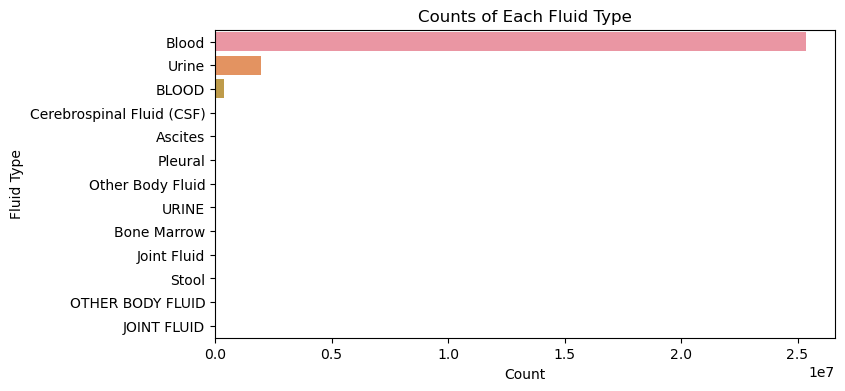

In [ ]:
# Plot fluid counts
plt.figure(figsize=(8, 4))
sns.barplot(y=fluid_counts.index, x=fluid_counts.values)

plt.title('Counts of Each Fluid Type')
plt.xlabel('Count')
plt.ylabel('Fluid Type')
plt.show()

The most common fluid type for lab test is blood.

## 10. MICROBIOLOGYEVENTS.csv

- CHARTDATE: The date the event occurred.
- CHARTTIME: The date and time the event occurred (if available).
- SPEC_ITEMID: Item ID for the specimen type.
- ORG_ITEMID: Item ID for the organism.
- ISOLATE_NUM: Number of organisms isolated from the same sample.
- AB_ITEMID: Item ID for the antibiotic.
- DILUTION_TEXT: Text description of the antibiotic dilution.
- DILUTION_COMPARISON: Comparison used for the antibiotic dilution.
- DILUTION_VALUE: Value of the antibiotic dilution.
- INTERPRETATION: Interpretation of the antibiotic dilution.

In [ ]:
# micro = pd.read_csv('data/MICROBIOLOGYEVENTS.csv')
micro

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,744,96,170324,2156-04-13 00:00:00,2156-04-13 14:18:00,70021.0,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,745,96,170324,2156-04-20 00:00:00,2156-04-20 13:10:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746,96,170324,2156-04-20 00:00:00,2156-04-20 16:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,747,96,170324,2156-04-20 00:00:00,NaN,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748,96,170324,2156-04-20 00:00:00,NaN,70079.0,URINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631721,630931,99783,126090,2125-11-05 00:00:00,2125-11-05 13:15:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,2.0,NaN,NaN,NaN,NaN,NaN,NaN
631722,630932,99783,126090,2125-11-06 00:00:00,2125-11-06 10:24:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,1.0,NaN,NaN,NaN,NaN,NaN,NaN
631723,630933,99783,126090,2125-11-06 00:00:00,2125-11-06 10:24:00,70076.0,TISSUE,80066.0,ASPERGILLUS FUMIGATUS,2.0,NaN,NaN,NaN,NaN,NaN,NaN
631724,630934,99783,126090,2125-11-07 00:00:00,2125-11-07 12:40:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
micro['ORG_NAME'].nunique()

362

There are 362 unique microorganisms in this dataset. Let's check what's the top 20 most common microorganisms.

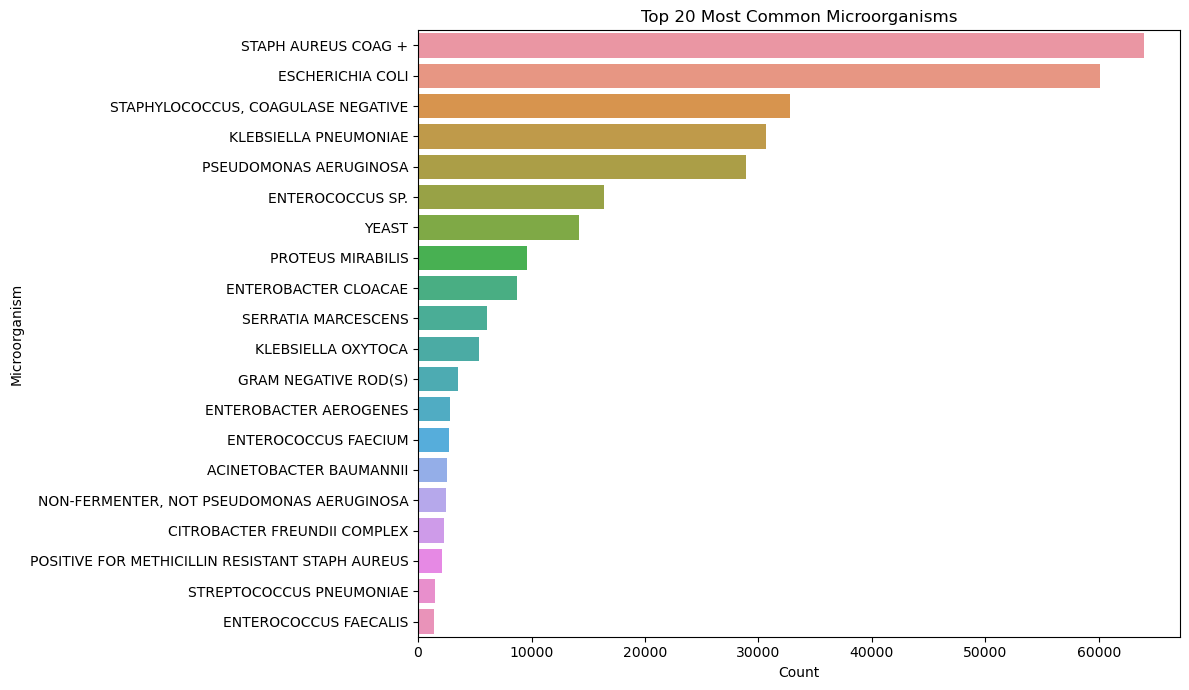

In [ ]:
# Get the top 20 most common microorganisms
top_microorganisms = micro['ORG_NAME'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(y=top_microorganisms.index, x=top_microorganisms.values)
plt.title('Top 20 Most Common Microorganisms')
plt.xlabel('Count')
plt.ylabel('Microorganism')
plt.tight_layout()
plt.show()

The chart above shows the most common microorganisms are Staphylococcus aureus and Escherichia coli.

In [ ]:
#!pip install networkx

A network graph where microorganisms and antibiotics are nodes, and edges represent associations (i.e., which antibiotic is tested against which organism).

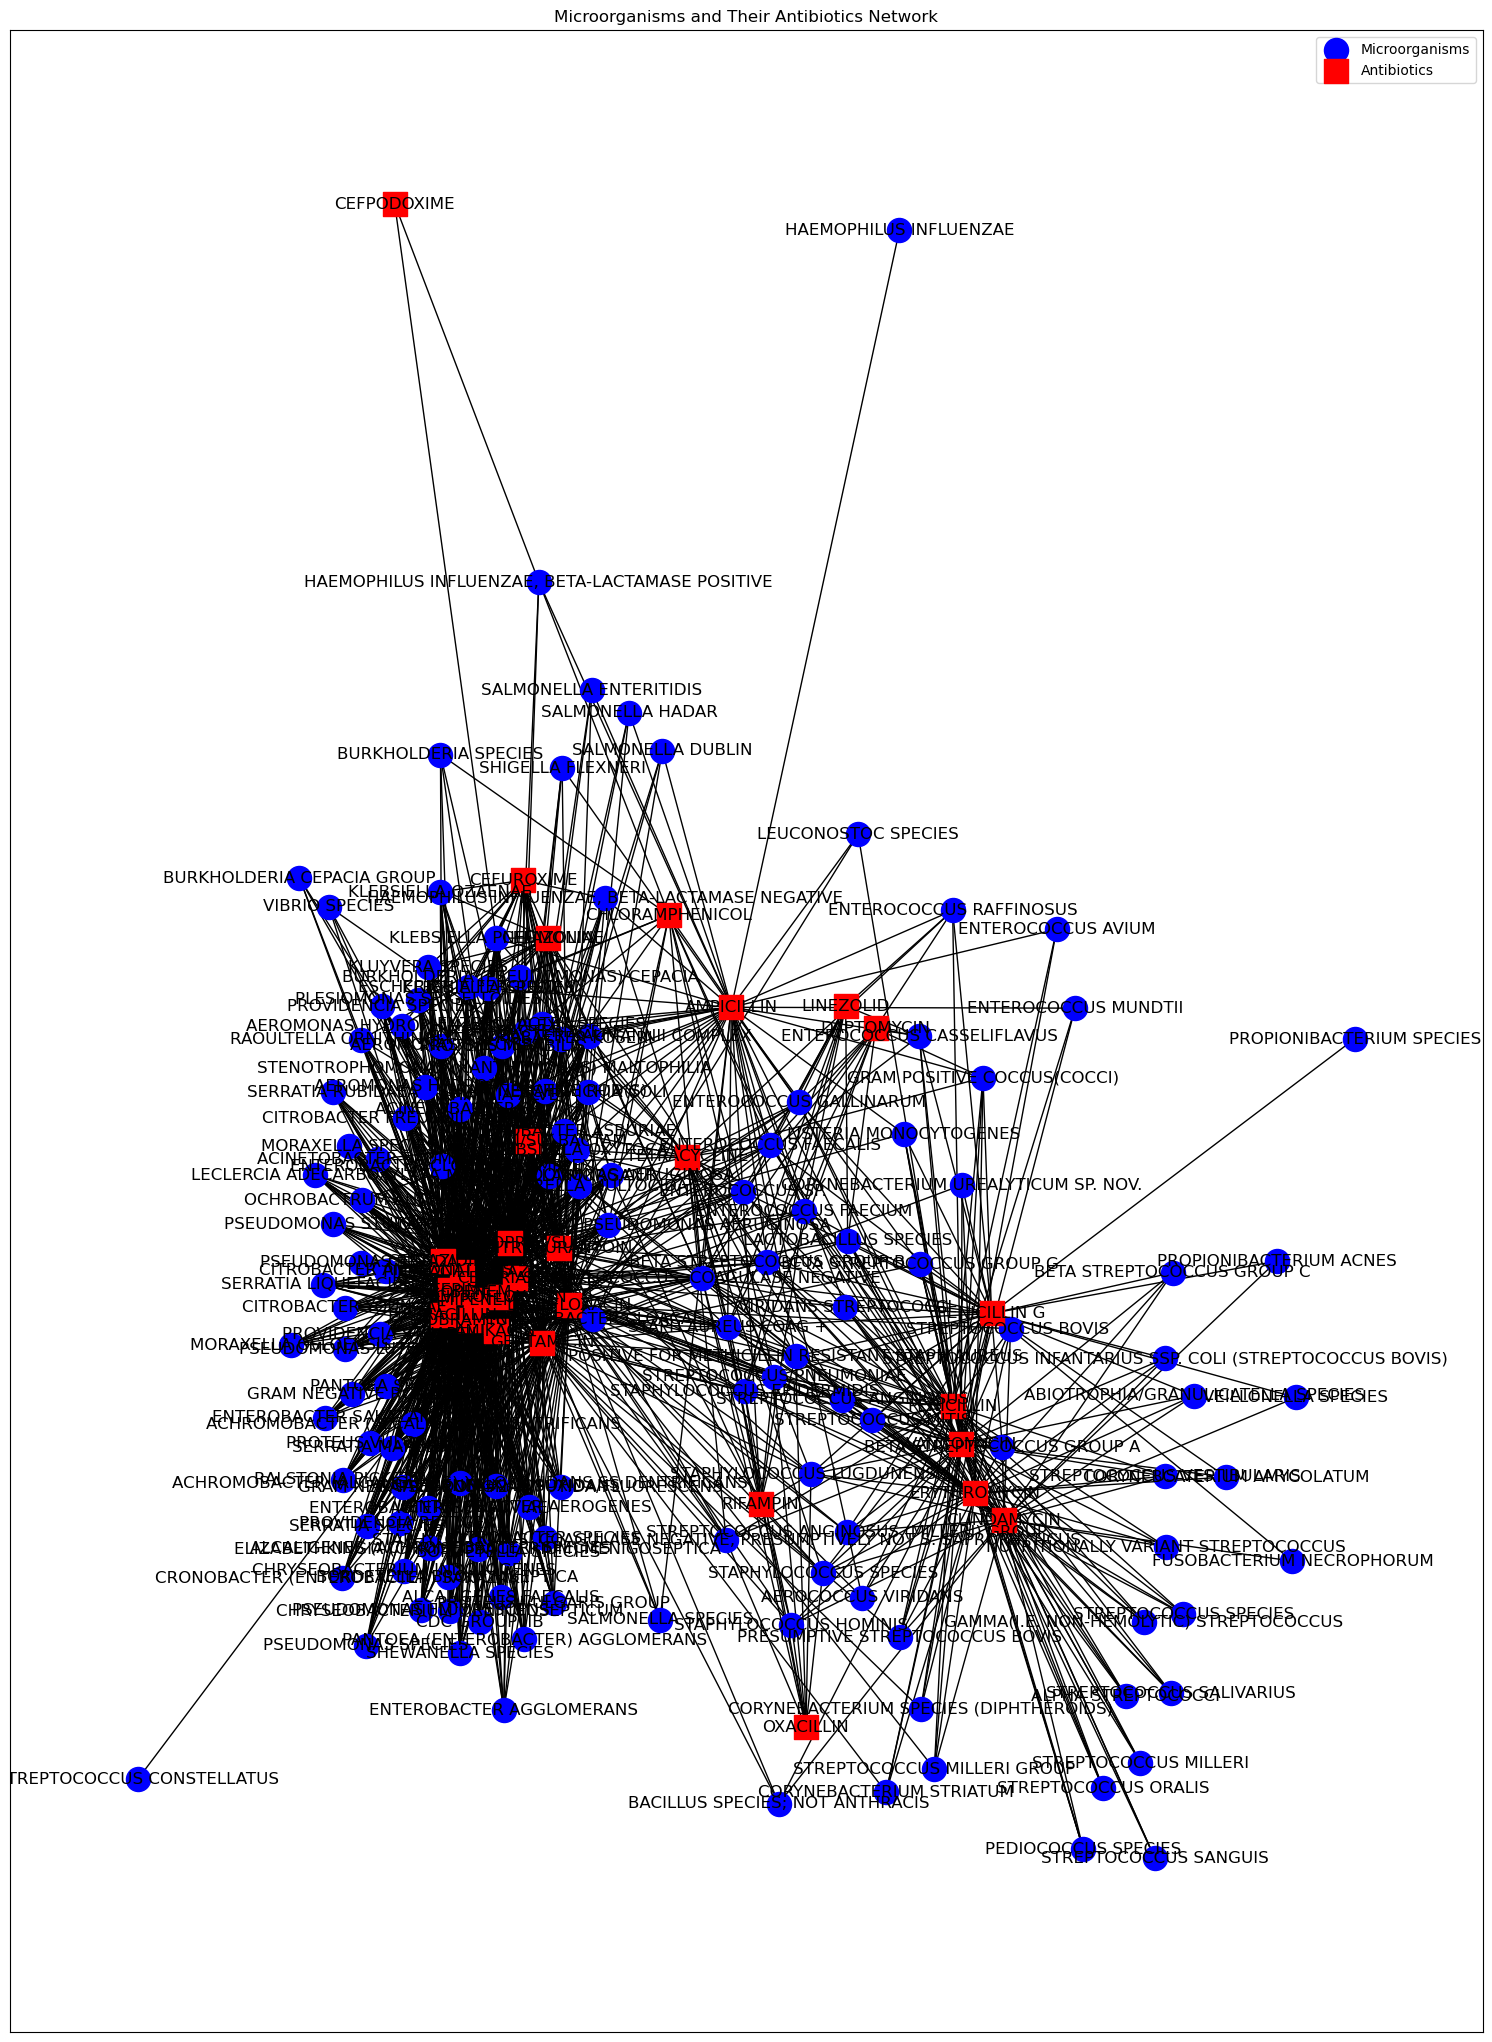

In [ ]:
# Create a new graph
G = nx.Graph()

# Add nodes for each microorganism and antibiotic
for org, ab in micro[['ORG_NAME', 'AB_NAME']].dropna().values:
    G.add_node(org, type='organism')
    G.add_node(ab, type='antibiotic')
    G.add_edge(org, ab)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(19, 26))

# Draw organisms
org_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'organism']
nx.draw_networkx_nodes(G, pos, nodelist=org_nodes, node_color='blue', label='Microorganisms')

# Draw antibiotics
ab_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'antibiotic']
nx.draw_networkx_nodes(G, pos, nodelist=ab_nodes, node_color='red', label='Antibiotics', node_shape='s')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
nx.draw_networkx_labels(G, pos)

plt.title('Microorganisms and Their Antibiotics Network')
plt.legend()
plt.show()

## 11. ICUSTAYS.csv

In [ ]:
# icustays = pd.read_csv('data/ICUSTAYS.csv')
icustays

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.1894
61528,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.4942
61529,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,0.9259
61530,59809,94954,118475,202802,metavision,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,2.3346


## 12. NOTEEVENTS.csv

In [ ]:
# noteevents = pd.read_csv('data/NOTEEVENTS.csv')
noteevents

/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_12577/836095148.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents = pd.read_csv('data/NOTEEVENTS.csv')


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...
...,...,...,...,...,...,...,...,...,...,...,...
2083175,2070657,31097,115637.0,2132-01-21,2132-01-21 03:27:00,2132-01-21 03:38:00,Nursing/other,Report,17581.0,NaN,NPN\n\n\n#1 Infant remains in RA with O2 sats...
2083176,2070658,31097,115637.0,2132-01-21,2132-01-21 09:50:00,2132-01-21 09:53:00,Nursing/other,Report,19211.0,NaN,"Neonatology\nDOL #5, CGA 36 weeks.\n\nCVR: Con..."
2083177,2070659,31097,115637.0,2132-01-21,2132-01-21 16:42:00,2132-01-21 16:44:00,Nursing/other,Report,20104.0,NaN,Family Meeting Note\nFamily meeting held with ...
2083178,2070660,31097,115637.0,2132-01-21,2132-01-21 18:05:00,2132-01-21 18:16:00,Nursing/other,Report,16023.0,NaN,NPN 1800\n\n\n#1 Resp: [**Known lastname 2243*...


In [ ]:
# Compute the lengths of the TEXT field
noteevents['text_length'] = noteevents['TEXT'].str.len()

# Find the maximum length
max_length = noteevents['text_length'].max()

# Find the average length
avg_length = noteevents['text_length'].mean()

print(f"Maximum length of TEXT: {max_length}")
print(f"Average length of TEXT: {avg_length:.2f}")

Maximum length of TEXT: 55728
Average length of TEXT: 1826.01


Use 2500 max length

### Use ClinicalBERT model by Hugging Face for processing the 'noteevents' data.

In [ ]:
#! pip install transformers torch

In [ ]:
#from transformers import BertTokenizer, BertModel

# Load the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# model = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# # Tokenize and process the notes
# def embed_text(text):
#     # Tokenize text (add special tokens and pad/truncate)
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=2500)

#     # Get embeddings
#     with torch.no_grad():
#         outputs = model(**inputs)

#     # Get the [CLS] token embeddings which can be used as sentence embeddings
#     embeddings = outputs.last_hidden_state[:, 0, :].numpy()

#     return embeddings

# noteevents['embeddings'] = noteevents['TEXT'].apply(embed_text)


## Other tables

In [ ]:
# d_items = pd.read_csv('data/D_ITEMS.csv')
d_items

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,458,498,PCA Lockout (Min),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,459,499,PCA Medication,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,460,500,PCA Total Dose,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,461,501,PCV Exh Vt (Obser),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12482,14518,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,metavision,chartevents,Scores - APACHE II,NaN,Text,NaN
12483,14519,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,metavision,chartevents,Scores - APACHE II,NaN,Text,NaN
12484,14520,226759,HCO3ApacheIIValue,HCO3ApacheIIValue,metavision,chartevents,Scores - APACHE II,None,Numeric,NaN
12485,14521,226760,HCO3Score,HCO3Score,metavision,chartevents,Scores - APACHE II,None,Numeric,NaN


In [ ]:
# callout = pd.read_csv('data/CALLOUT.csv')
callout

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,...,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,402,854,175684,52.0,NaN,29.0,MICU,1,MED,0,...,Inactive,Discharged,29.0,Acknowledged,2146-10-05 13:16:55,2146-10-05 13:16:55,2146-10-05 13:24:00,2146-10-05 18:55:22,2146-10-05 15:27:44,NaN
1,403,864,138624,15.0,NaN,55.0,CSRU,55,CSURG,0,...,Inactive,Discharged,55.0,Acknowledged,2114-11-28 08:31:39,2114-11-28 09:42:08,2114-11-28 09:43:08,2114-11-28 12:10:02,NaN,NaN
2,404,864,138624,12.0,NaN,55.0,CSRU,55,CSURG,1,...,Inactive,Discharged,55.0,Acknowledged,2114-11-30 10:24:25,2114-12-01 09:06:18,2114-12-01 12:26:05,2114-12-01 21:55:05,NaN,NaN
3,405,867,184298,7.0,NaN,17.0,CCU,17,CCU,1,...,Inactive,Discharged,17.0,Acknowledged,2136-12-29 08:45:42,2136-12-29 10:17:16,2136-12-29 10:33:51,2136-12-29 18:10:02,NaN,NaN
4,157,306,167129,57.0,NaN,3.0,SICU,44,NSURG,1,...,Inactive,Discharged,3.0,Acknowledged,2199-09-18 11:47:47,2199-09-18 11:47:47,2199-09-18 11:58:33,2199-09-18 15:10:02,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34494,32674,94046,199742,23.0,NaN,54.0,MICU,1,MED,1,...,Inactive,Discharged,54.0,Acknowledged,2112-11-01 11:13:04,2112-11-01 11:13:04,2112-11-01 11:16:14,2112-11-01 19:42:07,2112-11-01 16:12:28,NaN
34495,32675,94049,135809,23.0,NaN,45.0,MICU,1,MED,0,...,Inactive,Discharged,45.0,Acknowledged,2112-10-09 14:12:09,2112-10-09 14:12:09,2112-10-09 14:23:52,2112-10-09 17:40:05,NaN,NaN
34496,32676,94050,173013,23.0,NaN,45.0,MICU,1,MED,0,...,Inactive,Discharged,45.0,Acknowledged,2165-10-07 10:18:42,2165-10-07 10:18:42,2165-10-07 10:20:31,2165-10-07 19:10:11,2165-10-07 17:10:10,NaN
34497,32677,94056,172374,50.0,NaN,45.0,MICU,1,MED,0,...,Inactive,Discharged,45.0,Acknowledged,2199-10-30 15:35:30,2199-10-30 15:35:30,2199-10-30 16:16:09,2199-10-30 22:10:04,NaN,NaN


In [ ]:
# caregivers = pd.read_csv('data/CAREGIVERS.csv')
caregivers

,ROW_ID,CGID,LABEL,DESCRIPTION
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP
3,2231,16177,RO,Read Only
4,2232,16178,RT,Respiratory
...,...,...,...,...
7562,6300,20303,MD,NaN
7563,6301,20304,RN,RN
7564,6302,20305,MDs,NaN
7565,6303,20306,RPH,Pharmacist


In [ ]:
# cptevents = pd.read_csv('data/CPTEVENTS.csv')
cptevents

/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_12577/95051397.py:1: DtypeWarning: Columns (4,5,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  cptevents = pd.read_csv('data/CPTEVENTS.csv')


,ROW_ID,SUBJECT_ID,HADM_ID,COSTCENTER,CHARTDATE,CPT_CD,CPT_NUMBER,CPT_SUFFIX,TICKET_ID_SEQ,SECTIONHEADER,SUBSECTIONHEADER,DESCRIPTION
0,317,11743,129545,ICU,NaN,99232,99232.0,NaN,6.0,Evaluation and management,Hospital inpatient services,NaN
1,318,11743,129545,ICU,NaN,99232,99232.0,NaN,7.0,Evaluation and management,Hospital inpatient services,NaN
2,319,11743,129545,ICU,NaN,99232,99232.0,NaN,8.0,Evaluation and management,Hospital inpatient services,NaN
3,320,11743,129545,ICU,NaN,99232,99232.0,NaN,9.0,Evaluation and management,Hospital inpatient services,NaN
4,321,6185,183725,ICU,NaN,99223,99223.0,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
573141,573142,78876,163404,Resp,2105-09-01 00:00:00,94003,94003.0,NaN,NaN,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE)
573142,573143,78879,136071,Resp,2150-08-29 00:00:00,94003,94003.0,NaN,NaN,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE)
573143,573144,78879,136071,Resp,2150-08-28 00:00:00,94002,94002.0,NaN,NaN,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)"
573144,573145,78892,175171,Resp,2125-06-11 00:00:00,94003,94003.0,NaN,NaN,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE)


In [ ]:
d_cpt = pd.read_csv('data/D_CPT.csv')
d_cpt

,ROW_ID,CATEGORY,SECTIONRANGE,SECTIONHEADER,SUBSECTIONRANGE,SUBSECTIONHEADER,CODESUFFIX,MINCODEINSUBSECTION,MAXCODEINSUBSECTION
0,1,1,99201-99499,Evaluation and management,99201-99216,Office/other outpatient services,NaN,99201,99216
1,2,1,99201-99499,Evaluation and management,99217-99220,Hospital observation services,NaN,99217,99220
2,3,1,99201-99499,Evaluation and management,99221-99239,Hospital inpatient services,NaN,99221,99239
3,4,1,99201-99499,Evaluation and management,99241-99255,Consultations,NaN,99241,99255
4,5,1,99201-99499,Evaluation and management,99261-99263,Follow-up inpatient consultations (deleted codes),NaN,99261,99263
...,...,...,...,...,...,...,...,...,...
129,130,2,0001F-7025F,Performance measurement,5005F-5100F,Follow-up or other outcomes,F,5005,5100
130,131,2,0001F-7025F,Performance measurement,6005F-6045F,Patient safety,F,6005,6045
131,132,2,0001F-7025F,Performance measurement,7010F-7025F,Structural Measures,F,7010,7025
132,133,3,0016T-0207T,Emerging technology,0016T-0207T,Temporary codes,T,16,207


In [ ]:
# datetime_events = pd.read_csv('data/DATETIMEEVENTS.csv')
datetime_events

/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_12577/1648525581.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  datetime_events = pd.read_csv('data/DATETIMEEVENTS.csv')


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,711,7657,121183.0,297945.0,3411,2172-03-14 11:00:00,2172-03-14 11:52:00,16446,NaN,Date,NaN,NaN,NaN,NotStopd
1,712,7657,121183.0,297945.0,3411,2172-03-14 13:00:00,2172-03-14 12:36:00,16446,NaN,Date,NaN,NaN,NaN,NotStopd
2,713,7657,121183.0,297945.0,3411,2172-03-14 15:00:00,2172-03-14 15:10:00,14957,NaN,Date,NaN,NaN,NaN,NotStopd
3,714,7657,121183.0,297945.0,3411,2172-03-14 17:00:00,2172-03-14 17:01:00,16446,NaN,Date,NaN,NaN,NaN,NotStopd
4,715,7657,121183.0,297945.0,3411,2172-03-14 19:00:00,2172-03-14 19:29:00,14815,NaN,Date,NaN,NaN,NaN,NotStopd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485932,4456093,99366,136021.0,218447.0,224279,2197-03-24 16:32:00,2197-03-24 16:32:00,18234,2197-03-24 13:03:00,Date and Time,0.0,0.0,NaN,NaN
4485933,4456094,99366,136021.0,218447.0,224280,2197-03-24 16:32:00,2197-03-24 16:32:00,18234,2197-03-24 00:00:00,Date,0.0,0.0,NaN,NaN
4485934,4456095,99366,136021.0,218447.0,224282,2197-03-24 16:32:00,2197-03-24 16:32:00,18234,2197-03-24 00:00:00,Date,0.0,0.0,NaN,NaN
4485935,4456096,99366,136021.0,218447.0,224284,2197-03-24 16:32:00,2197-03-24 16:32:00,18234,2197-03-24 00:00:00,Date,0.0,0.0,NaN,NaN


In [ ]:
# drgcodes = pd.read_csv('data/DRGCODES.csv')
drgcodes

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
...,...,...,...,...,...,...,...,...
125552,123452,71582,101422,MS,221,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,NaN,NaN
125553,123453,46449,110075,APR,1653,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,3.0,2.0
125554,123454,46449,110075,APR,1653,Coronary Bypass w/ Cardiac Cath Or Percutaneou...,3.0,2.0
125555,123455,46449,110075,MS,234,CORONARY BYPASS W CARDIAC CATH W/O MCC,NaN,NaN


In [ ]:
print(drgcodes['DRG_TYPE'].unique())


['HCFA' 'APR ' 'MS']


In [ ]:
# inputevents_cv = pd.read_csv('data/INPUTEVENTS_CV.csv')
inputevents_cv

/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_12577/29830721.py:1: DtypeWarning: Columns (7,9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  inputevents_cv = pd.read_csv('data/INPUTEVENTS_CV.csv')


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,RATEUOM,...,ORDERID,LINKORDERID,STOPPED,NEWBOTTLE,ORIGINALAMOUNT,ORIGINALAMOUNTUOM,ORIGINALROUTE,ORIGINALRATE,ORIGINALRATEUOM,ORIGINALSITE
0,592,24457,184834.0,205776.0,2193-09-11 09:00:00,30056,100.0,ml,NaN,NaN,...,756654,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
1,593,24457,184834.0,205776.0,2193-09-11 12:00:00,30056,200.0,ml,NaN,NaN,...,3564075,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
2,594,24457,184834.0,205776.0,2193-09-11 16:00:00,30056,160.0,ml,NaN,NaN,...,422646,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
3,595,24457,184834.0,205776.0,2193-09-11 19:00:00,30056,240.0,ml,NaN,NaN,...,5137889,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
4,596,24457,184834.0,205776.0,2193-09-11 21:00:00,30056,50.0,ml,NaN,NaN,...,8343792,9359133,NaN,NaN,NaN,ml,Oral,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527930,17422687,27946,169481.0,212466.0,2154-07-16 22:00:00,40864,82.0,ml,NaN,NaN,...,10296124,4180996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17527931,17422688,27946,169481.0,212466.0,2154-07-16 23:00:00,40864,82.0,ml,NaN,NaN,...,10248887,4180996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17527932,17422689,27946,169481.0,212466.0,2154-07-17 00:00:00,40864,NaN,ml,NaN,NaN,...,7418343,4180996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17527933,17422690,30516,132490.0,260091.0,2105-08-25 06:30:00,46046,31.0,ml,NaN,NaN,...,1753414,4180996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#inputevents_mv = pd.read_csv('data/INPUTEVENTS_MV.csv')
inputevents_mv

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,...,TOTALAMOUNTUOM,ISOPENBAG,CONTINUEINNEXTDEPT,CANCELREASON,STATUSDESCRIPTION,COMMENTS_EDITEDBY,COMMENTS_CANCELEDBY,COMMENTS_DATE,ORIGINALAMOUNT,ORIGINALRATE
0,241,27063,139787,223259.0,2133-02-05 06:29:00,2133-02-05 08:45:00,225166,6.774532,mEq,NaN,...,ml,0,0,1,Rewritten,NaN,RN,2133-02-05 12:52:00,10.000000,0.050000
1,242,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 06:30:00,225944,28.132997,ml,30.142497,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,28.132998,30.255817
2,243,27063,139787,223259.0,2133-02-05 05:34:00,2133-02-05 06:30:00,225166,2.813300,mEq,NaN,...,ml,0,0,0,FinishedRunning,NaN,NaN,NaN,2.813300,0.050426
3,244,27063,139787,223259.0,2133-02-03 12:00:00,2133-02-03 12:01:00,225893,1.000000,dose,NaN,...,ml,0,0,2,Rewritten,RN,NaN,2133-02-03 17:06:00,1.000000,1.000000
4,245,27063,139787,223259.0,2133-02-03 12:00:00,2133-02-03 12:01:00,220949,100.000000,ml,NaN,...,ml,0,0,2,Rewritten,RN,NaN,2133-02-03 17:06:00,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618986,3568968,90959,136680,240741.0,2147-08-28 12:00:00,2147-08-28 12:01:00,221744,99.999997,mcg,NaN,...,NaN,0,0,0,FinishedRunning,NaN,NaN,NaN,100.000000,100.000000
3618987,3568969,90959,136680,240741.0,2147-08-29 12:16:00,2147-08-29 15:04:00,225942,0.842267,mg,300.809532,...,ml,0,0,0,Paused,NaN,NaN,NaN,2.500000,300.000000
3618988,3568970,90959,136680,240741.0,2147-08-29 12:16:00,2147-08-29 15:04:00,225943,16.845331,ml,6.016190,...,ml,0,0,0,Paused,NaN,NaN,NaN,50.000000,6.000000
3618989,3568971,90959,136680,240741.0,2147-08-29 02:30:00,2147-08-29 02:31:00,221744,99.999997,mcg,NaN,...,NaN,0,0,0,FinishedRunning,NaN,NaN,NaN,100.000000,100.000000


In [ ]:
# outputevents = pd.read_csv('data/OUTPUTEVENTS.csv')
outputevents

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,VALUE,VALUEUOM,STORETIME,CGID,STOPPED,NEWBOTTLE,ISERROR
0,344,21219,177991.0,225765.0,2142-09-08 10:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
1,345,21219,177991.0,225765.0,2142-09-08 12:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
2,346,21219,177991.0,225765.0,2142-09-08 13:00:00,40055,120.0,ml,2142-09-08 13:39:00,17269,NaN,NaN,NaN
3,347,21219,177991.0,225765.0,2142-09-08 14:00:00,40055,100.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN
4,348,21219,177991.0,225765.0,2142-09-08 16:00:00,40055,200.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4349213,4340476,68375,123645.0,276251.0,2175-09-05 23:00:00,226588,30.0,mL,2175-09-05 22:48:00,16915,NaN,NaN,NaN
4349214,4340477,68375,123645.0,276251.0,2175-09-06 00:00:00,226588,0.0,mL,2175-09-06 00:03:00,20971,NaN,NaN,NaN
4349215,4340478,68375,123645.0,276251.0,2175-09-06 01:00:00,226588,40.0,mL,2175-09-06 01:13:00,20971,NaN,NaN,NaN
4349216,4340479,68375,123645.0,276251.0,2175-09-06 02:00:00,226588,20.0,mL,2175-09-06 02:14:00,20971,NaN,NaN,NaN


In [ ]:
# prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv')
prescriptions

/var/folders/75/wcn_lvz57xb_nfjnjhymkwl40000gn/T/ipykernel_12577/2209474424.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('data/PRESCRIPTIONS.csv')


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,4.690617e+08,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,5.601728e+07,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,3.380550e+08,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.000000e+00,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,5.482972e+07,20mg Tablet,20,mg,1,TAB,PO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156445,3996662,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,PredniSONE,PredniSONE,PredniSONE,PRED20,006751,5.400182e+07,20 mg Tablet,40,mg,2,TAB,PO/NG
4156446,3996070,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,Ipratropium Bromide Neb,Ipratropium Bromide Neb,Ipratropium Bromide Neb,IPRA2H,021700,4.879801e+08,2.5mL Vial,1,NEB,1,VIAL,IH
4156447,3996063,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,HYDROmorphone (Dilaudid),HYDROmorphone (Dilaudid),HYDROmorphone,HYDR20/100NS,048078,6.155302e+10,20 mg / 100 mL Premix Bag,0.12,mg,0.01,BAG,IVPCA
4156448,3996062,98887,121032,238144.0,2144-09-06 00:00:00,2144-09-06 00:00:00,MAIN,Docusate Sodium,Docusate Sodium,Docusate Sodium,DOCU100,003009,9.042245e+08,100mg Capsule,100,mg,1,CAP,PO


In [ ]:
# services = pd.read_csv('data/SERVICES.csv')
services

,ROW_ID,SUBJECT_ID,HADM_ID,TRANSFERTIME,PREV_SERVICE,CURR_SERVICE
0,758,471,135879,2122-07-22 14:07:27,TSURG,MED
1,759,471,135879,2122-07-26 18:31:49,MED,TSURG
2,760,472,173064,2172-09-28 19:22:15,NaN,CMED
3,761,473,129194,2201-01-09 20:16:45,NaN,NB
4,762,474,194246,2181-03-23 08:24:41,NaN,NB
...,...,...,...,...,...,...
73338,72914,98932,174244,2176-08-13 20:28:00,NaN,CMED
73339,72915,98939,115549,2166-11-15 01:21:49,NaN,NMED
73340,72916,98941,141129,2118-02-08 01:52:28,NaN,CSURG
73341,72917,98943,193747,2164-11-14 20:04:12,NaN,TRAUM


In [ ]:
# transfers = pd.read_csv('data/TRANSFERS.csv')
transfers

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
0,657,111,192123,254245.0,carevue,transfer,CCU,MICU,7.0,23.0,2142-04-29 15:27:11,2142-05-04 20:38:33,125.19
1,658,111,192123,NaN,carevue,transfer,MICU,NaN,23.0,45.0,2142-05-04 20:38:33,2142-05-05 11:46:32,15.13
2,659,111,192123,NaN,carevue,discharge,NaN,NaN,45.0,NaN,2142-05-05 11:46:32,NaN,NaN
3,660,111,155897,249202.0,metavision,admit,NaN,MICU,NaN,52.0,2144-07-01 04:13:59,2144-07-01 05:19:39,1.09
4,661,111,155897,NaN,metavision,transfer,MICU,NaN,52.0,32.0,2144-07-01 05:19:39,2144-07-01 06:28:29,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261892,259671,98385,195599,NaN,metavision,transfer,NaN,NaN,36.0,49.0,2108-10-06 11:27:11,2108-10-06 13:05:57,1.65
261893,259672,98385,195599,292167.0,metavision,transfer,NaN,SICU,49.0,33.0,2108-10-06 13:05:57,2108-10-11 17:00:31,123.91
261894,259673,98385,195599,NaN,metavision,discharge,SICU,NaN,33.0,NaN,2108-10-11 17:00:31,NaN,NaN
261895,259674,98389,155368,NaN,metavision,admit,NaN,NaN,NaN,29.0,2153-10-14 22:12:58,2153-10-14 22:21:06,0.14


## Preprocess tables for merging

In [ ]:
# Drop specified columns from the DataFrame
admission_merged = admission_merged.drop(columns=['ROW_ID_x', 'ROW_ID_y'])
admission_merged

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,HAS_CHARTEVENTS_DATA,DEATH_STATUS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DEATH_HOSP,AGE_AT_ADMISSION
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,1,Alive,F,2131-05-07,NaN,NaN,NaN,0,Alive,64.0
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,1,Alive,M,2082-07-17,NaN,NaN,NaN,0,Alive,71.0
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,...,1,Alive,M,2082-07-17,NaN,NaN,NaN,0,Alive,75.0
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,1,Alive,M,2100-05-31,NaN,NaN,NaN,0,Alive,39.0
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,...,1,Alive,M,2101-11-21,NaN,NaN,NaN,0,Alive,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,...,1,Alive,F,2111-11-05,NaN,NaN,NaN,0,Alive,19.0
58972,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,...,1,Died,F,2067-09-21,2151-03-06 00:00:00,2151-03-06 00:00:00,NaN,1,Died,83.0
58973,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,...,1,Alive,M,2158-03-02,NaN,NaN,NaN,0,Alive,42.0
58974,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,...,0,Alive,F,2068-02-04,NaN,NaN,NaN,0,Alive,60.0


In [ ]:
#diagnosis_merged

In [ ]:
#procedure_merged

In [ ]:
#lab_merged

In [ ]:
#micro

## Use Autoencoder on admission_merged, followed by UMAP to visualise latent space

1. Preprocess the Data: Most columns in the admission_merged table seem to be of a non-numeric type. We'll need to preprocess the data to convert non-numeric fields into a format suitable for training. One of the common techniques is to use one-hot encoding for categorical data. However, be cautious with date fields and fields with a large number of unique values, as one-hot encoding might not be the best choice for them.

2. Build an Autoencoder: We'll use Keras for this.

3. Train the Autoencoder.

4. Extract Latent Features.

5. Apply UMAP.

6. Visualize the Results.

Autoencoder example notebook: https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb

## Try Clustering on admission_merged

## Find top features related to UTI

In [ ]:
# diagnosis_icd[diagnosis_icd['LONG_TITLE'].apply(lambda x:True if 'urinary tract infection' in x.lower() else False)]

In [ ]:
# import pandas as pd
# import numpy as np
# import sweetviz

# admissions= pd.read_csv("data/ADMISSIONS.csv")
# icd = pd.read_csv('data/DIAGNOSES_ICD.csv')
# icd_desc = pd.read_csv('data/D_ICD_DIAGNOSES.csv')
# #Bloods
# bloods = pd.read_csv('data/LABEVENTS.csv')

# #microbiology
# micro = pd.read_csv('data/MICROBIOLOGYEVENTS.csv')

# lab_items = pd.read_csv('data/D_LABITEMS.csv')
# items = lab_items = pd.read_csv('data/D_ITEMS.csv')

# final_df = pd.merge(bloods, lab_items, on ='ITEMID')
# micro_merged = pd.merge(micro, items, left_on='SPEC_ITEMID', right_on='ITEMID')
# icd_merged = pd.merge(icd, icd_desc, on='ICD9_CODE')
# out_df = sweetviz.analyze(admissions[['ETHNICITY','DIAGNOSIS','SUBJECT_ID']])
# uti_icd9 = icd_merged[icd_merged['LONG_TITLE'].apply(lambda x:\
#                                                      'urinary tract' in x.lower())]

# np.random.seed(0)
# hadm_uti = list(set(uti_icd9['HADM_ID'].sample(100)))

Neo4j

In [ ]:
# LOAD CSV WITH HEADERS FROM 'file:///uti.csv' as uti
# MERGE (a:Admission{id:uti.HADM_ID})
# MERGE (icd:ICD{id:uti.SHORT_TITLE})
# MERGE (a)-[:HAS]->(icd)

# MATCH (n:ICD)
# WHERE n.id="Urin tract infection NOS"
# RETURN (n)

# MATCH (a:Admission)-[r:HAS]->(icd:ICD{id:'Urin tract infection NOS'})
# MATCH (a)-[r2:HAS]->(otherICDs)
# WHERE NOT (icd=otherICDs)
# RETURN otherICDs,COUNT(r2) as popularity
# ORDER BY popularity DESC

In [1]:
def plot_vertical_categorical_data(column_name, df, top_n):
    df_counts = df[column_name].value_counts()
    top_X = df_counts.head(top_n)
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=top_X.index, y=top_X.values)
    
    plt.title('Top '+str(top_n)+' Most Common ' + column_name)
    plt.xlabel(column_name)
    plt.ylabel('Number of Admissions')
    plt.xticks(rotation=45, ha='right')  # Rotate the diagnosis names for better readability
    plt.tight_layout()
    plt.show()
    
plot_vertical_categorical_data('DIAGNOSIS', admissions, top_n=20)

NameError: name 'admissions' is not defined